In [53]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [54]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/delve_source_2/delve_source_2.npy'
target_img_path = head / 'data/delve_target_2/delve_target_2.npy'
source_meta = head / 'data/delve_source_2/delve_source_2_metadata.csv'
target_meta = head / 'data/delve_target_2/delve_target_2_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

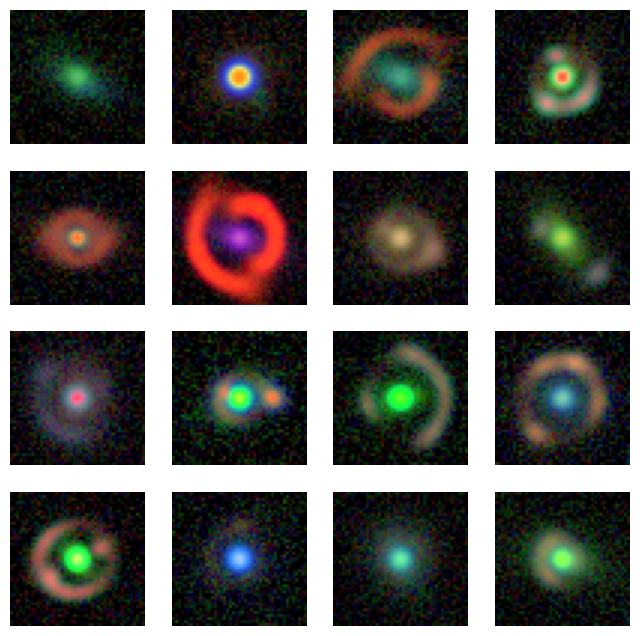

In [55]:
# Visualize source data
visualize_data(source_data)

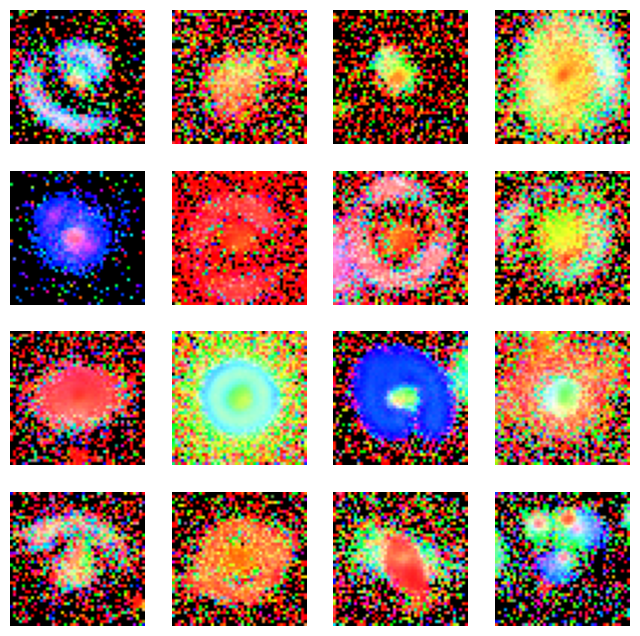

In [56]:
# Visualize target data
visualize_data(target_data)

In [57]:
from matplotlib.colors import PowerNorm

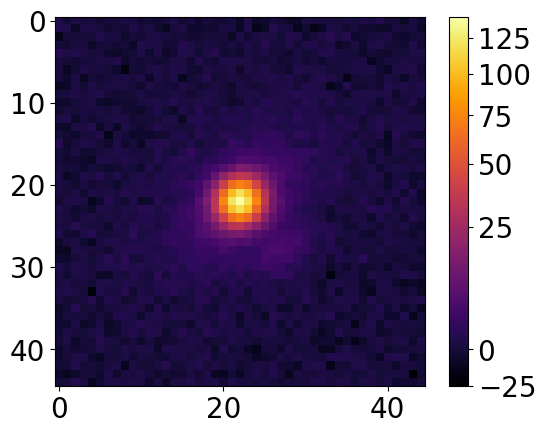

In [182]:
plt.imshow(source_data[212, 0, :, :], norm = PowerNorm(0.5), cmap = 'inferno')
plt.colorbar()

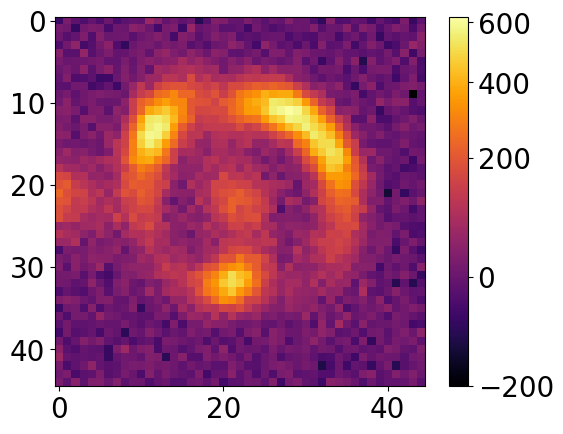

In [183]:
plt.imshow(target_data[2990, 0, :, :], norm = PowerNorm(0.5), cmap = 'inferno')
plt.colorbar()

In [61]:
source_metatab = pd.read_csv(source_meta)
target_metatab = pd.read_csv(target_meta)

In [171]:
source_metatab.iloc[86, 30:60]

PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g           1.678239
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g           2.910787
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g                -0.178983
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e2-g                 0.106216
PLANE_1-OBJECT_1-MASS_PROFILE_1-NAME-g                     SIE
PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g              2.15743
PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g                 -0.174456
PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g                  0.182545
PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g                 0.0
PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g                 0.0
PLANE_2-OBJECT_1-REDSHIFT-g                           1.341871
PLANE_2-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g                  1
PLANE_2-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g                  0
PLANE_2-OBJECT_1-NUMBER_OF_MASS_PROFILES-g                   1
PLANE_2-OBJECT_1-HOST-g                                    NaN
PLANE_2-OBJECT_1-LIGHT_PROFILE_1-NAME-g         SERSIC_

In [71]:
list(source_metatab.keys())

['OBJID-g',
 'H0-g',
 'Om0-g',
 'exposure_time-g',
 'numPix-g',
 'pixel_scale-g',
 'psf_type-g',
 'read_noise-g',
 'ccd_gain-g',
 'seeing-g',
 'magnitude_zero_point-g',
 'sky_brightness-g',
 'num_exposures-g',
 'NUMBER_OF_NOISE_SOURCES-g',
 'CONFIGURATION_LABEL-g',
 'CONFIGURATION_NAME-g',
 'NUMBER_OF_PLANES-g',
 'PLANE_1-NUMBER_OF_OBJECTS-g',
 'PLANE_1-OBJECT_1-NAME-g',
 'PLANE_2-NUMBER_OF_OBJECTS-g',
 'PLANE_2-OBJECT_1-NAME-g',
 'PLANE_1-OBJECT_1-REDSHIFT-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g',
 'PLANE_1-OBJECT_1-HOST-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-NAME-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e

(array([5063., 5062., 4990., 4980., 4868., 5061., 4990., 4953., 5034.,
        4998.]),
 array([200.005178  , 230.00368555, 260.00219309, 290.00070063,
        319.99920817, 349.99771571, 379.99622326, 409.9947308 ,
        439.99323834, 469.99174588, 499.99025342]),
 <BarContainer object of 10 artists>)

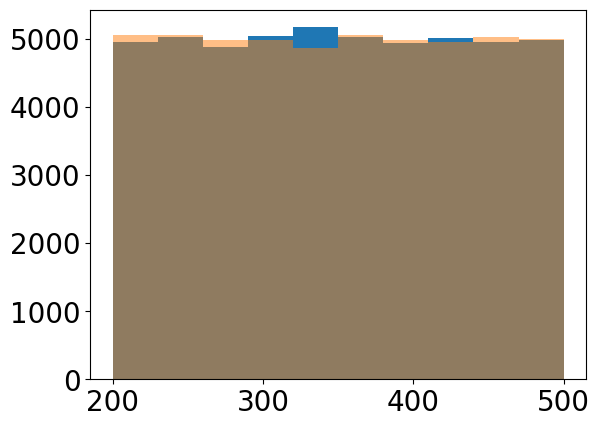

In [144]:
b = 10#np.linspace(0, 1, 20)
plt.hist(source_metatab['PLANE_2-OBJECT_1-MASS_PROFILE_1-sigma_v-g'], bins = b)
plt.hist(target_metatab['PLANE_2-OBJECT_1-MASS_PROFILE_1-sigma_v-g'], bins = b, alpha = 0.5)

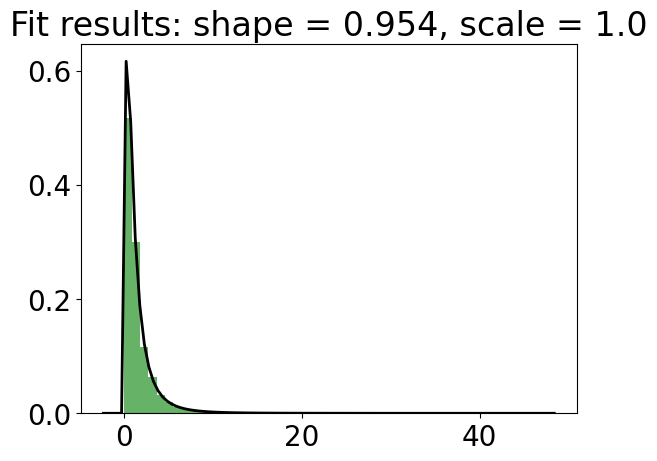

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Parameters for the lognormal distribution
shape = 1.6  # Shape parameter (sigma)
scale = np.exp(0)  # Scale parameter (exp(mu))
size = 10000  # Number of samples

# Generate random samples from the lognormal distribution
samples = lognorm.rvs(s=shape, scale=scale, size=size)

# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# Plot the theoretical lognormal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, s=shape, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

title = f"Fit results: shape = {shape}, scale = {scale}"
plt.title(title)

plt.show()

In [46]:
model = NeuralNetwork(npix=45).cuda()
learning_rate = 1e-5
epochs = 200
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [47]:
mod_name = "models/mb_lenscolor_jul25_0200" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


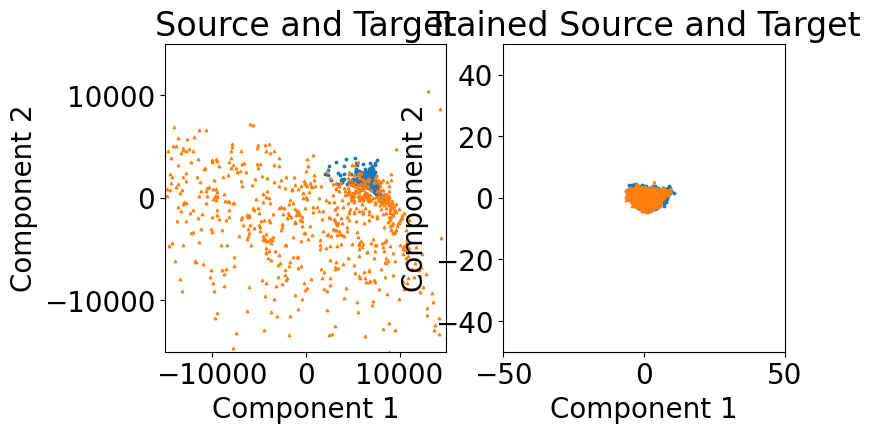

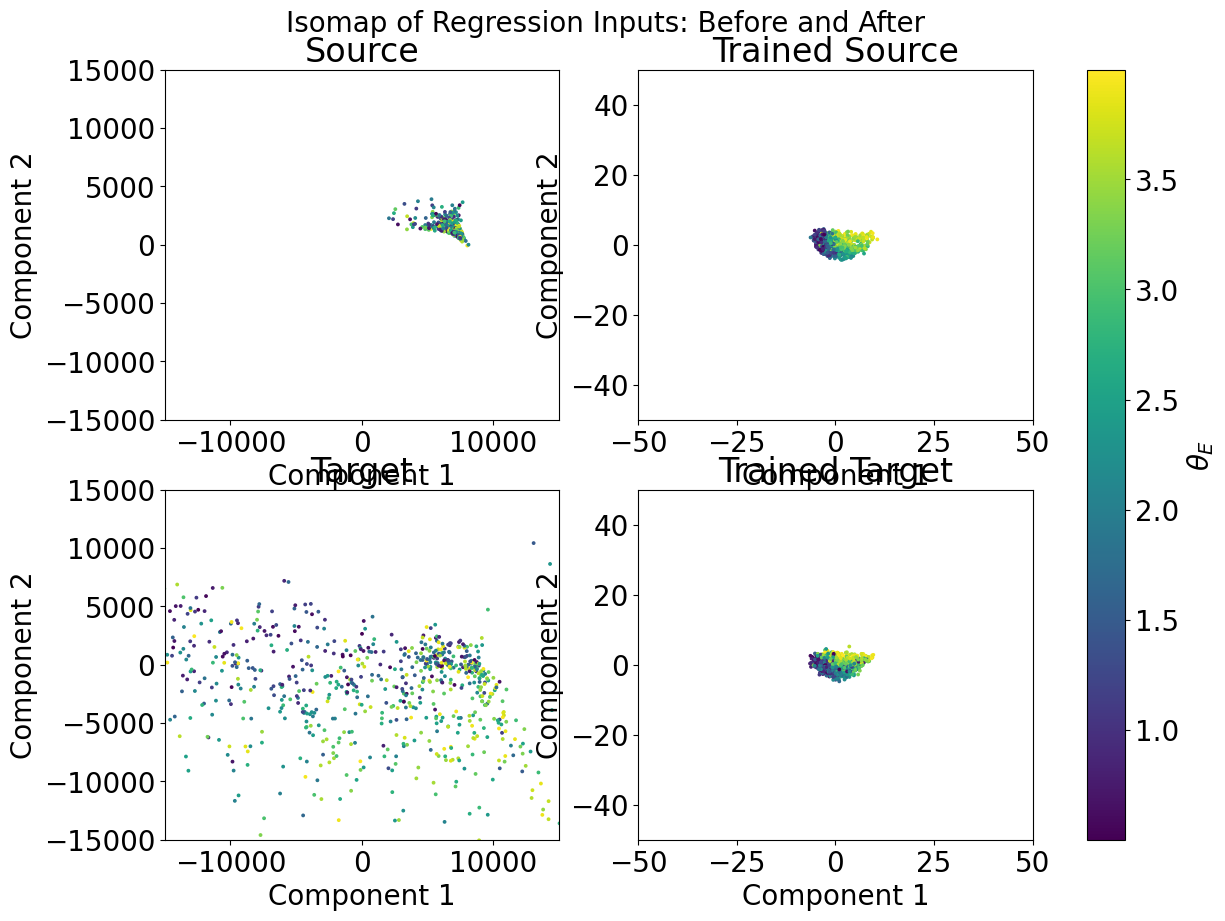


Epoch 50: 23.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1876
	Train Regression Loss: : 0.1002
	Train R2 Score: : 0.8974
 Validation Statistics:
	Val Source Regression Loss: : 0.1066
	Val Target Regression Loss: : 0.3442
	Val Source R2 Score: : 0.8892
	Val Target R2 Score: : 0.6516

Epoch 51: 19.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1893
	Train Regression Loss: : 0.1071
	Train R2 Score: : 0.8893
 Validation Statistics:
	Val Source Regression Loss: : 0.1153
	Val Target Regression Loss: : 0.3401
	Val Source R2 Score: : 0.8804
	Val Target R2 Score: : 0.6509

Epoch 52: 15.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1892
	Train Regression Loss: : 0.1124
	Train R2 Score: : 0.8850
 Validation Statistics:
	Val Source Regression Loss: : 0.1207
	Val Target Regression Loss: : 0.3380
	Val Source R2 Score: : 0.8719
	Val Target R2 Score: : 0.6565

Epoch 53: 15.37s
----------------------------

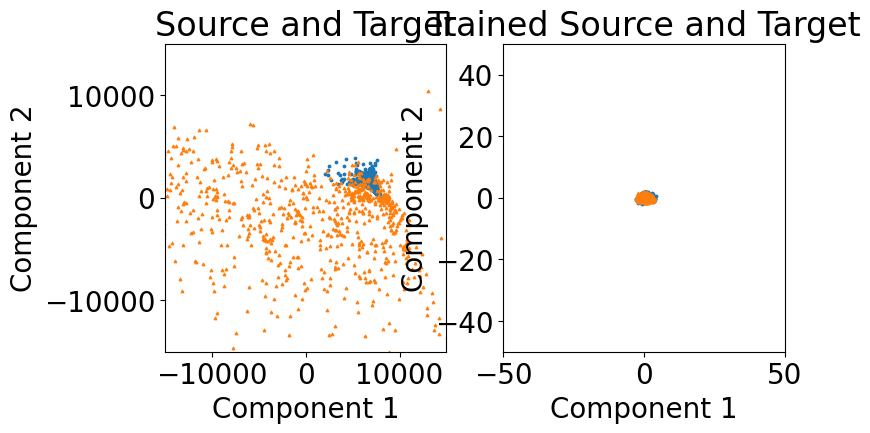

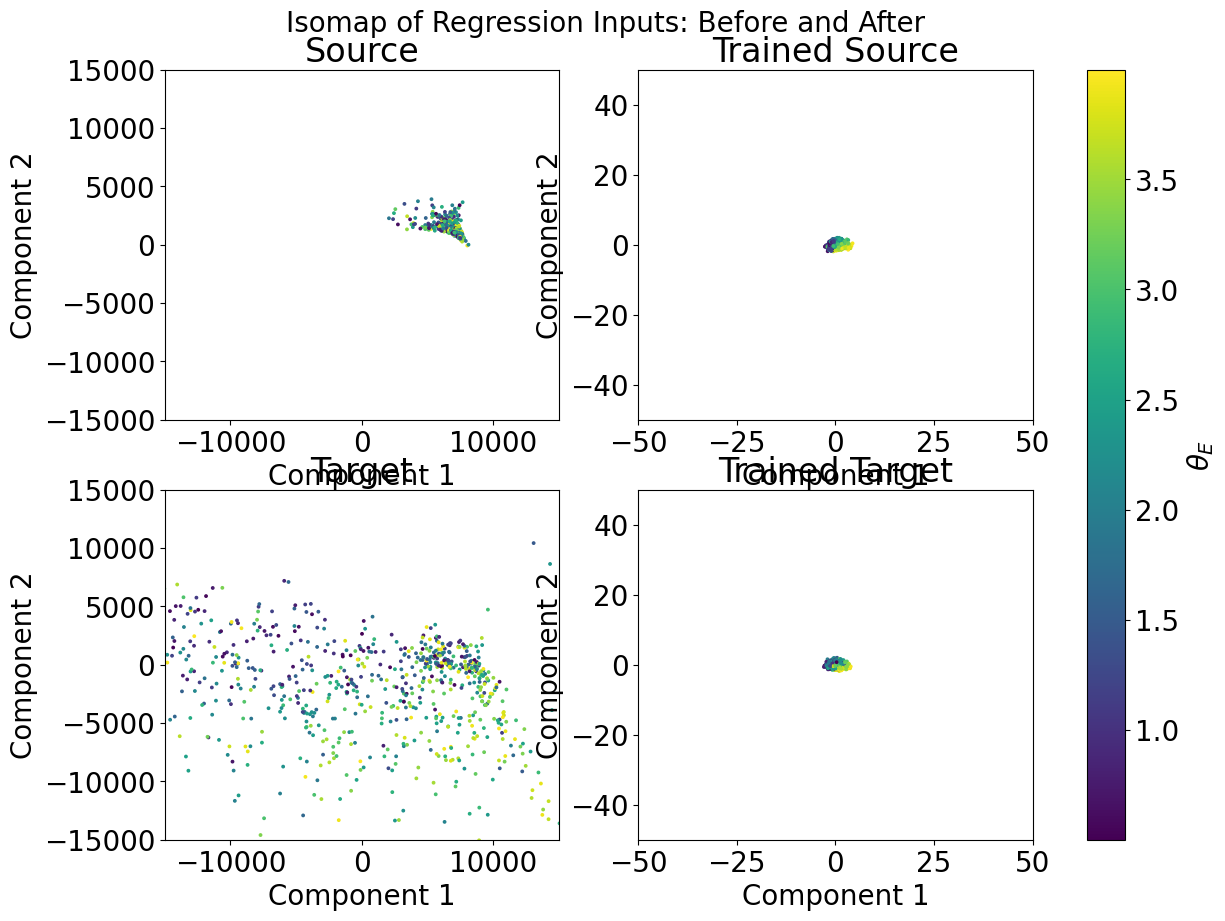


Epoch 55: 22.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1912
	Train Regression Loss: : 0.1285
	Train R2 Score: : 0.8685
 Validation Statistics:
	Val Source Regression Loss: : 0.1287
	Val Target Regression Loss: : 0.3442
	Val Source R2 Score: : 0.8665
	Val Target R2 Score: : 0.6480

Epoch 56: 17.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1926
	Train Regression Loss: : 0.1332
	Train R2 Score: : 0.8634
 Validation Statistics:
	Val Source Regression Loss: : 0.1404
	Val Target Regression Loss: : 0.3762
	Val Source R2 Score: : 0.8543
	Val Target R2 Score: : 0.6137

Epoch 57: 15.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1935
	Train Regression Loss: : 0.1351
	Train R2 Score: : 0.8625
 Validation Statistics:
	Val Source Regression Loss: : 0.1368
	Val Target Regression Loss: : 0.3381
	Val Source R2 Score: : 0.8577
	Val Target R2 Score: : 0.6551

Epoch 58: 14.27s
----------------------------

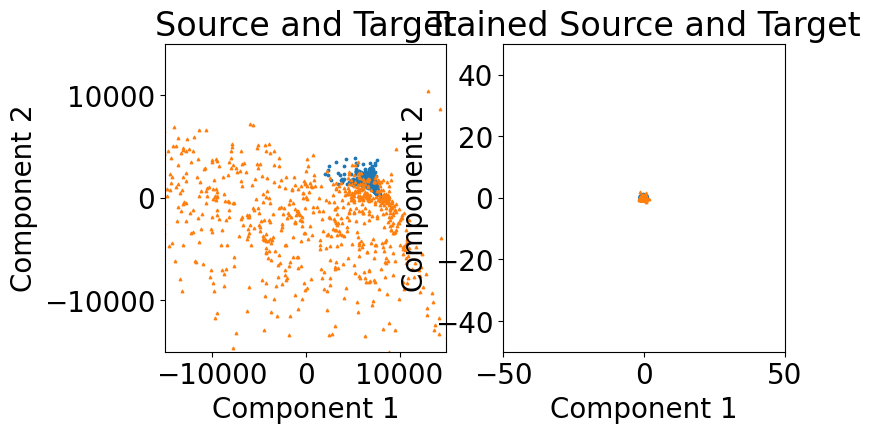

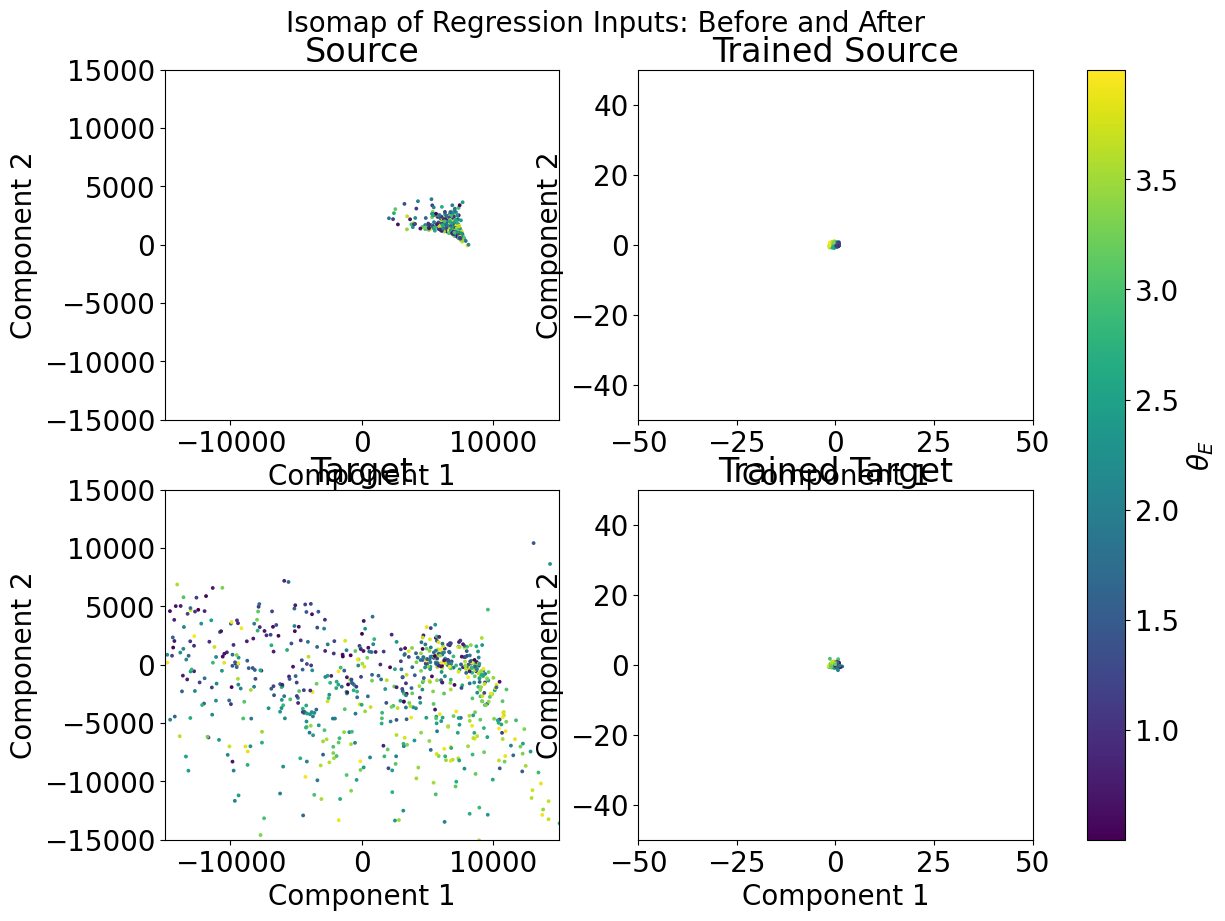


Epoch 60: 19.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1942
	Train Regression Loss: : 0.1451
	Train R2 Score: : 0.8518
 Validation Statistics:
	Val Source Regression Loss: : 0.1412
	Val Target Regression Loss: : 0.3342
	Val Source R2 Score: : 0.8533
	Val Target R2 Score: : 0.6569

Epoch 61: 18.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1924
	Train Regression Loss: : 0.1494
	Train R2 Score: : 0.8466
 Validation Statistics:
	Val Source Regression Loss: : 0.1460
	Val Target Regression Loss: : 0.3393
	Val Source R2 Score: : 0.8476
	Val Target R2 Score: : 0.6587

Epoch 62: 19.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1920
	Train Regression Loss: : 0.1504
	Train R2 Score: : 0.8462
 Validation Statistics:
	Val Source Regression Loss: : 0.1509
	Val Target Regression Loss: : 0.3378
	Val Source R2 Score: : 0.8326
	Val Target R2 Score: : 0.6564

Epoch 63: 18.37s
----------------------------

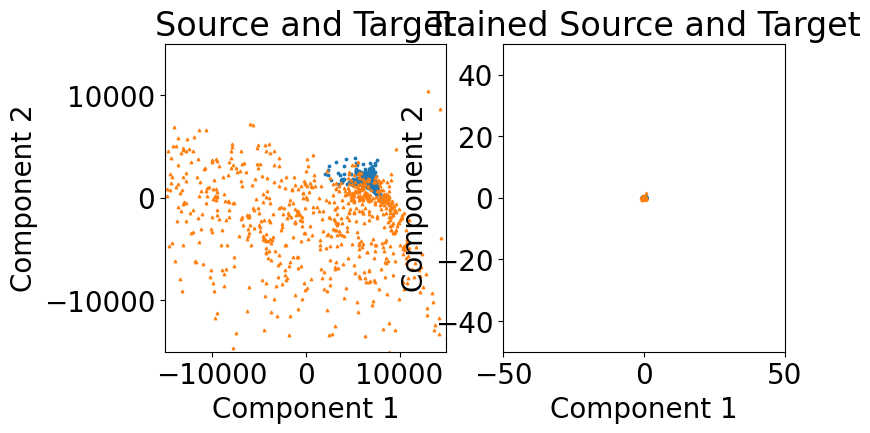

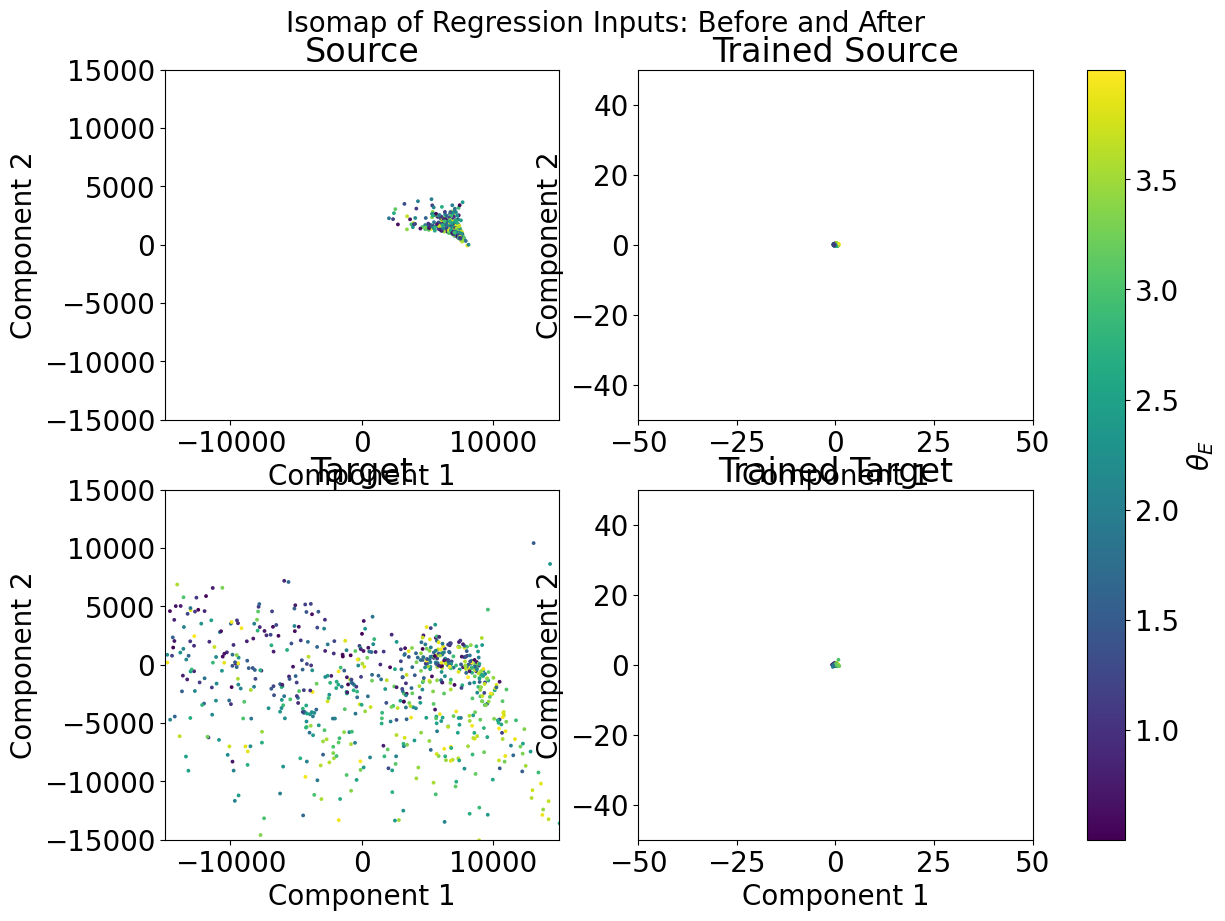


Epoch 65: 18.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1925
	Train Regression Loss: : 0.1593
	Train R2 Score: : 0.8370
 Validation Statistics:
	Val Source Regression Loss: : 0.1746
	Val Target Regression Loss: : 0.3781
	Val Source R2 Score: : 0.8193
	Val Target R2 Score: : 0.6120

Epoch 66: 17.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1929
	Train Regression Loss: : 0.1629
	Train R2 Score: : 0.8335
 Validation Statistics:
	Val Source Regression Loss: : 0.1606
	Val Target Regression Loss: : 0.3439
	Val Source R2 Score: : 0.8318
	Val Target R2 Score: : 0.6507

Epoch 67: 15.84s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1926
	Train Regression Loss: : 0.1662
	Train R2 Score: : 0.8302
 Validation Statistics:
	Val Source Regression Loss: : 0.1604
	Val Target Regression Loss: : 0.3254
	Val Source R2 Score: : 0.8342
	Val Target R2 Score: : 0.6698

Epoch 68: 16.91s
----------------------------

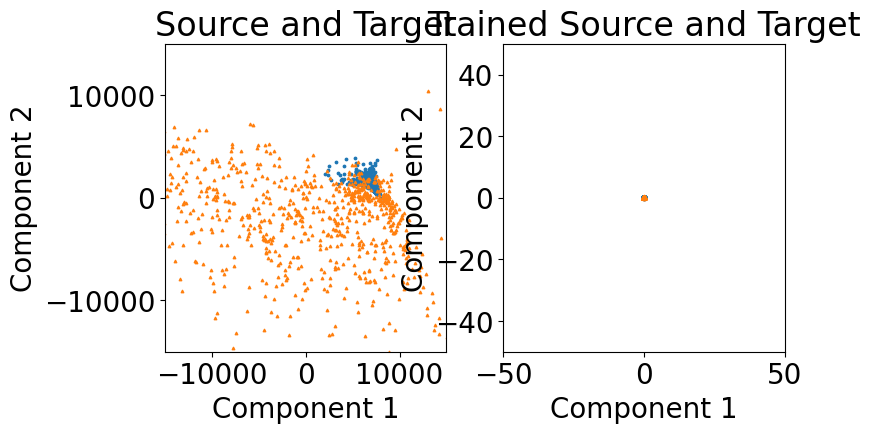

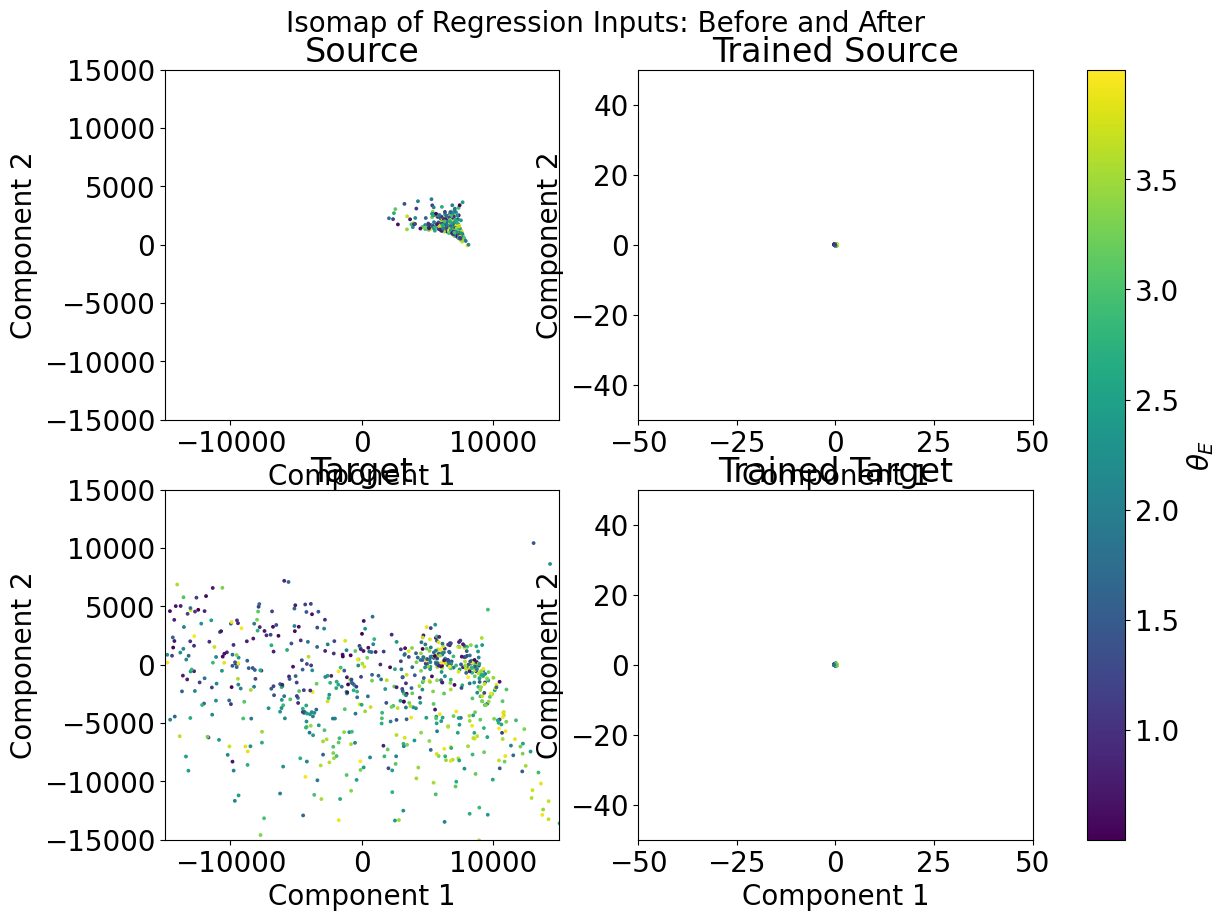


Epoch 70: 18.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1951
	Train Regression Loss: : 0.1729
	Train R2 Score: : 0.8231
 Validation Statistics:
	Val Source Regression Loss: : 0.1720
	Val Target Regression Loss: : 0.3248
	Val Source R2 Score: : 0.8206
	Val Target R2 Score: : 0.6687

Epoch 71: 14.91s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1951
	Train Regression Loss: : 0.1745
	Train R2 Score: : 0.8221
 Validation Statistics:
	Val Source Regression Loss: : 0.1718
	Val Target Regression Loss: : 0.3267
	Val Source R2 Score: : 0.8202
	Val Target R2 Score: : 0.6710

Epoch 72: 16.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1951
	Train Regression Loss: : 0.1779
	Train R2 Score: : 0.8185
 Validation Statistics:
	Val Source Regression Loss: : 0.1706
	Val Target Regression Loss: : 0.3281
	Val Source R2 Score: : 0.8238
	Val Target R2 Score: : 0.6664

Epoch 73: 14.32s
----------------------------

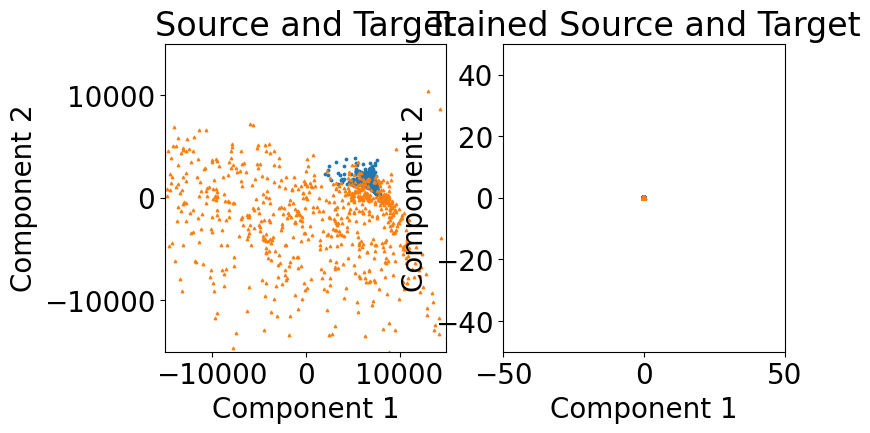

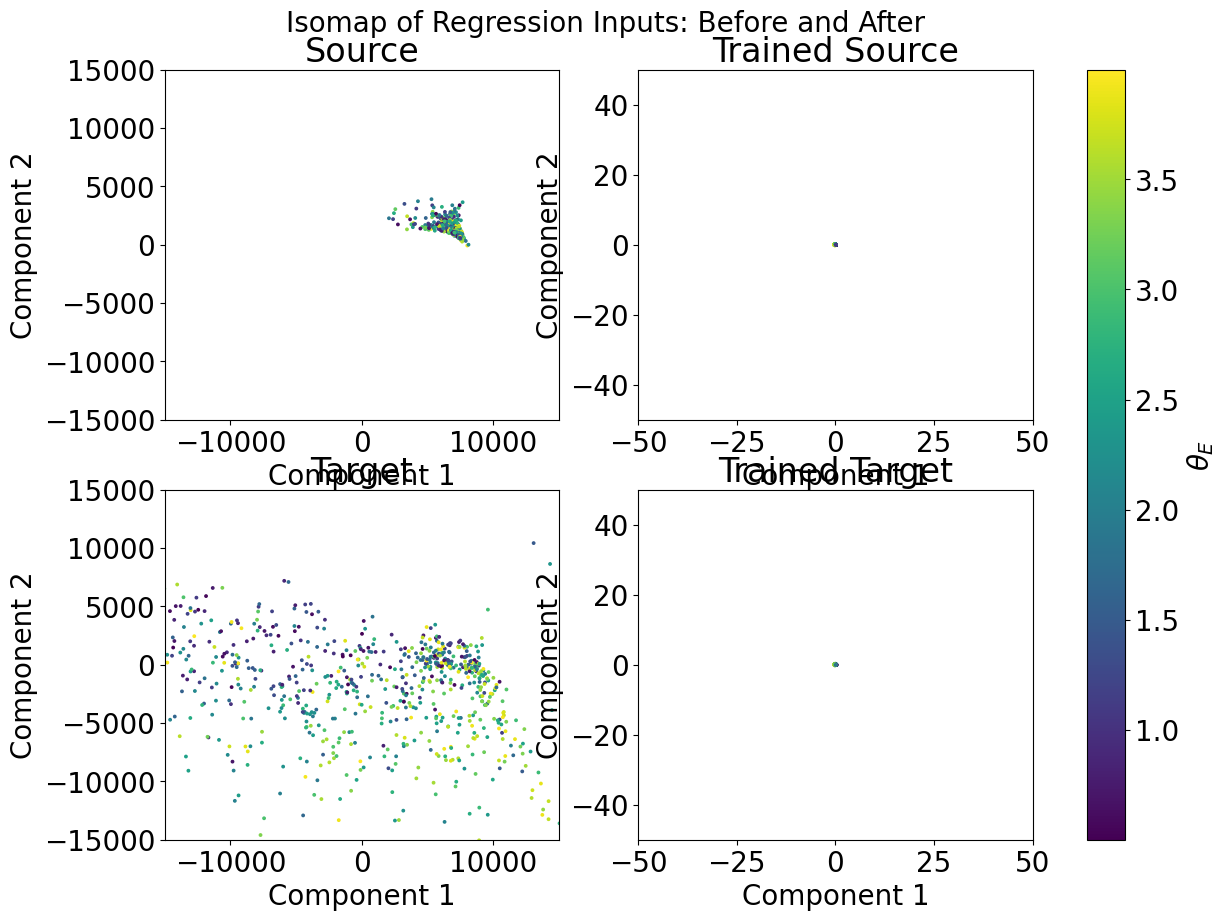


Epoch 75: 18.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1950
	Train Regression Loss: : 0.1838
	Train R2 Score: : 0.8130
 Validation Statistics:
	Val Source Regression Loss: : 0.1878
	Val Target Regression Loss: : 0.3453
	Val Source R2 Score: : 0.8065
	Val Target R2 Score: : 0.6458

Epoch 76: 21.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1961
	Train Regression Loss: : 0.1852
	Train R2 Score: : 0.8109
 Validation Statistics:
	Val Source Regression Loss: : 0.2019
	Val Target Regression Loss: : 0.3654
	Val Source R2 Score: : 0.7899
	Val Target R2 Score: : 0.6327

Epoch 77: 17.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1960
	Train Regression Loss: : 0.1878
	Train R2 Score: : 0.8080
 Validation Statistics:
	Val Source Regression Loss: : 0.2024
	Val Target Regression Loss: : 0.3629
	Val Source R2 Score: : 0.7916
	Val Target R2 Score: : 0.6347

Epoch 78: 15.71s
----------------------------

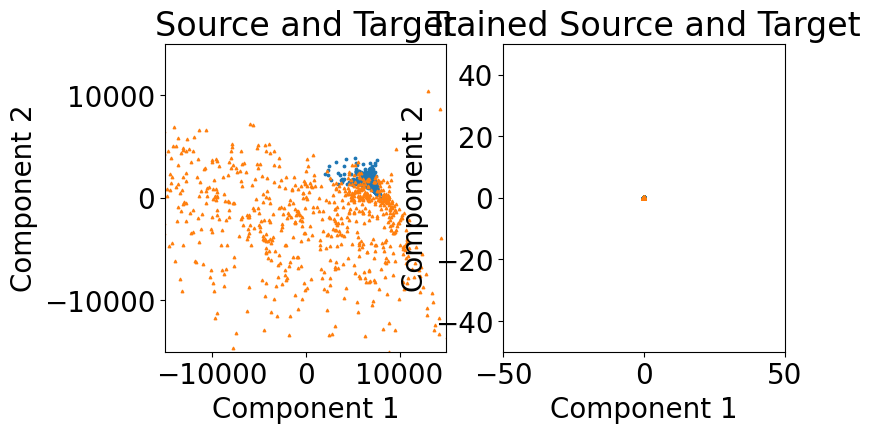

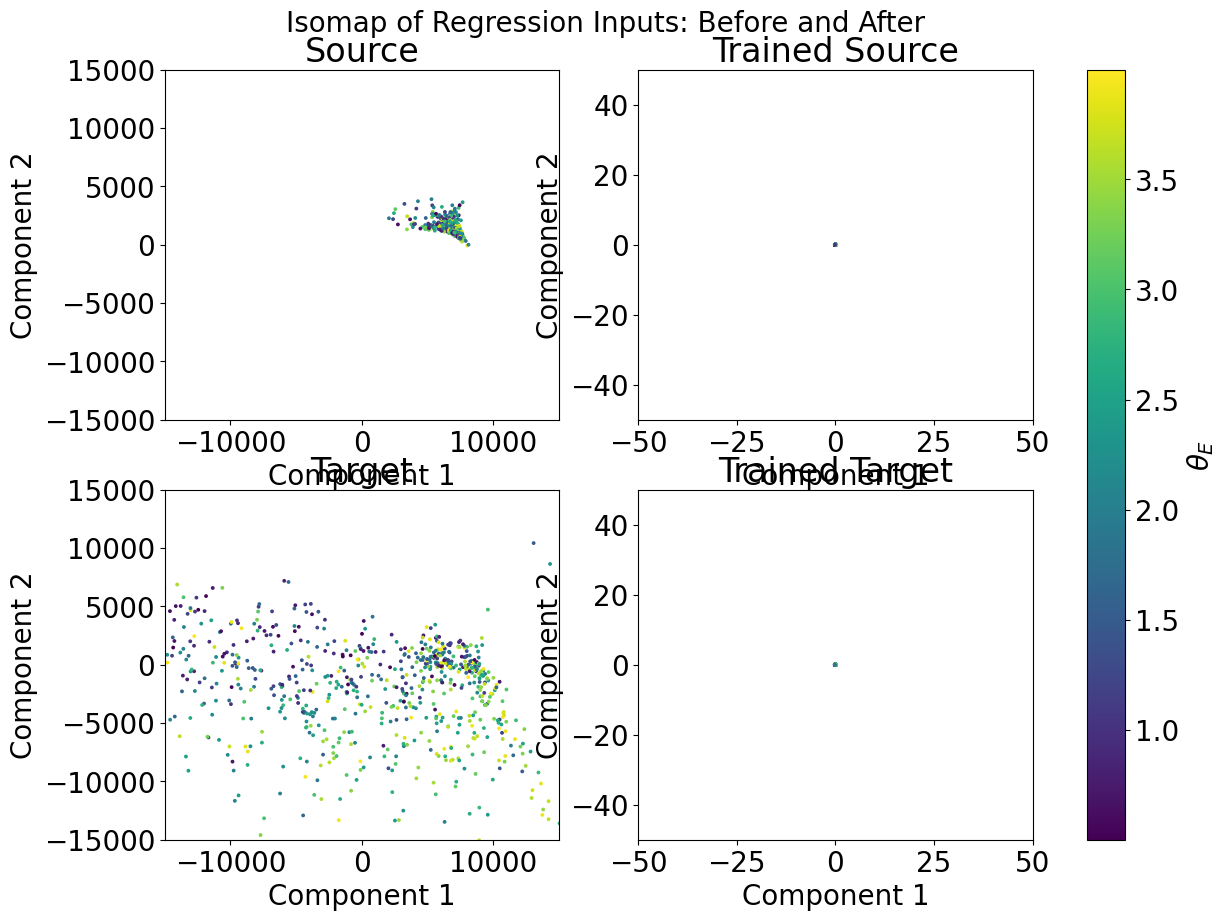


Epoch 80: 19.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1956
	Train Regression Loss: : 0.1931
	Train R2 Score: : 0.8032
 Validation Statistics:
	Val Source Regression Loss: : 0.1873
	Val Target Regression Loss: : 0.3448
	Val Source R2 Score: : 0.8066
	Val Target R2 Score: : 0.6507

Epoch 81: 16.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1967
	Train Regression Loss: : 0.1931
	Train R2 Score: : 0.8032
 Validation Statistics:
	Val Source Regression Loss: : 0.1899
	Val Target Regression Loss: : 0.3336
	Val Source R2 Score: : 0.8033
	Val Target R2 Score: : 0.6582

Epoch 82: 17.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1960
	Train Regression Loss: : 0.1968
	Train R2 Score: : 0.8005
 Validation Statistics:
	Val Source Regression Loss: : 0.1855
	Val Target Regression Loss: : 0.3224
	Val Source R2 Score: : 0.8072
	Val Target R2 Score: : 0.6721

Epoch 83: 16.52s
----------------------------

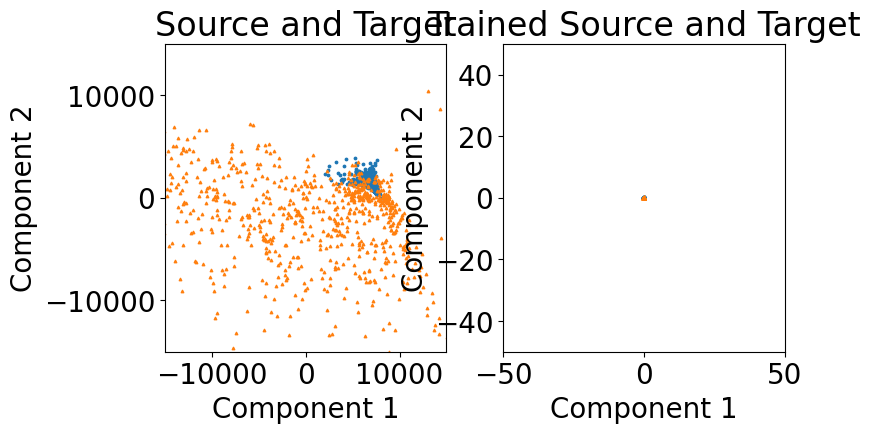

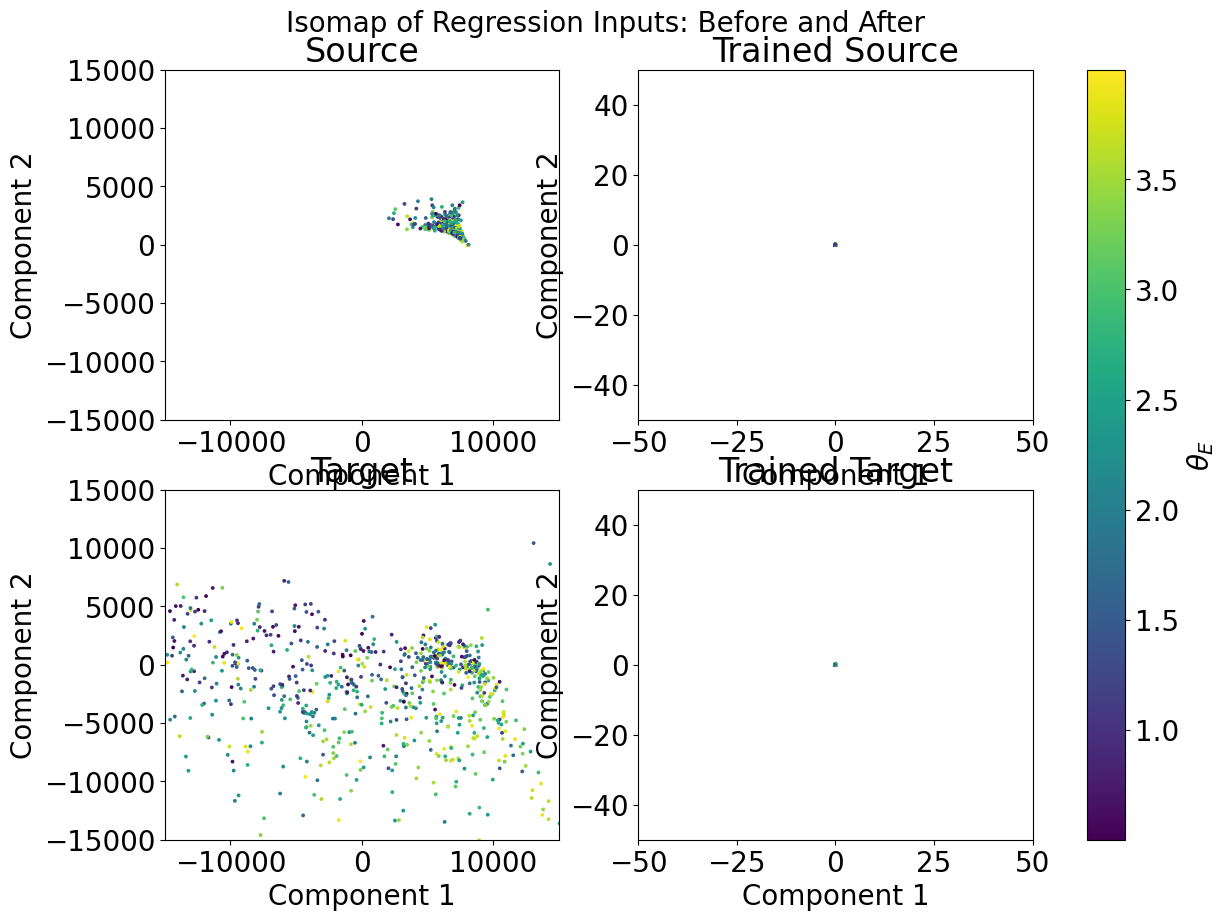


Epoch 85: 19.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1958
	Train Regression Loss: : 0.2058
	Train R2 Score: : 0.7909
 Validation Statistics:
	Val Source Regression Loss: : 0.2229
	Val Target Regression Loss: : 0.3705
	Val Source R2 Score: : 0.7684
	Val Target R2 Score: : 0.6217

Epoch 86: 14.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1954
	Train Regression Loss: : 0.2114
	Train R2 Score: : 0.7849
 Validation Statistics:
	Val Source Regression Loss: : 0.2031
	Val Target Regression Loss: : 0.3396
	Val Source R2 Score: : 0.7911
	Val Target R2 Score: : 0.6588

Epoch 87: 15.25s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1957
	Train Regression Loss: : 0.2149
	Train R2 Score: : 0.7814
 Validation Statistics:
	Val Source Regression Loss: : 0.2055
	Val Target Regression Loss: : 0.3424
	Val Source R2 Score: : 0.7884
	Val Target R2 Score: : 0.6528

Epoch 88: 14.54s
----------------------------

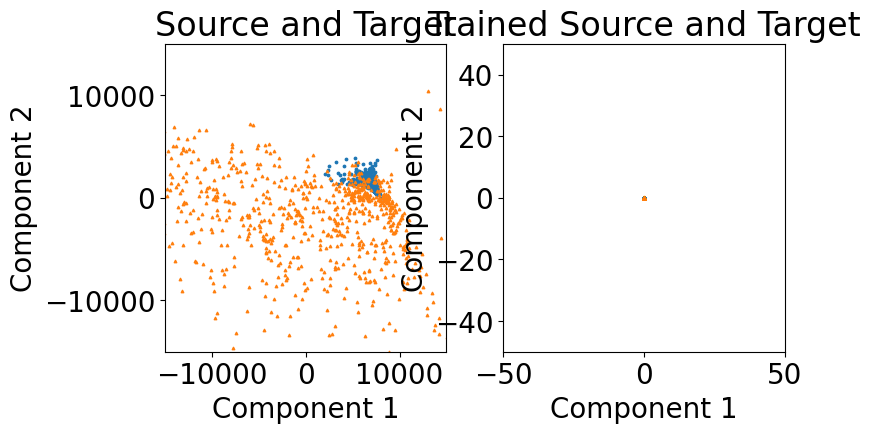

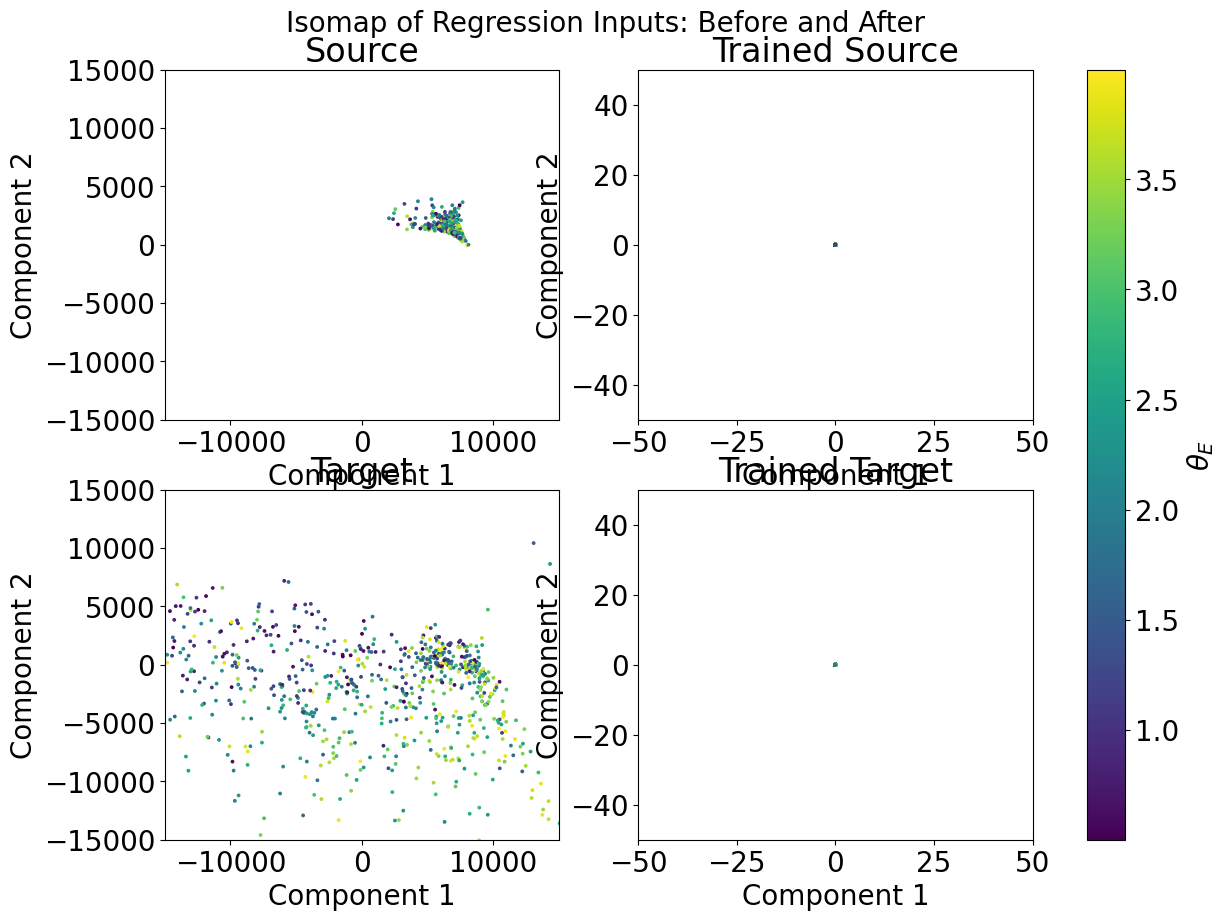


Epoch 90: 18.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1944
	Train Regression Loss: : 0.2255
	Train R2 Score: : 0.7702
 Validation Statistics:
	Val Source Regression Loss: : 0.2056
	Val Target Regression Loss: : 0.3445
	Val Source R2 Score: : 0.7879
	Val Target R2 Score: : 0.6519

Epoch 91: 15.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1955
	Train Regression Loss: : 0.2302
	Train R2 Score: : 0.7662
 Validation Statistics:
	Val Source Regression Loss: : 0.2125
	Val Target Regression Loss: : 0.3415
	Val Source R2 Score: : 0.7801
	Val Target R2 Score: : 0.6591

Epoch 92: 15.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1940
	Train Regression Loss: : 0.2324
	Train R2 Score: : 0.7638
 Validation Statistics:
	Val Source Regression Loss: : 0.2232
	Val Target Regression Loss: : 0.3634
	Val Source R2 Score: : 0.7696
	Val Target R2 Score: : 0.6330

Epoch 93: 13.71s
----------------------------

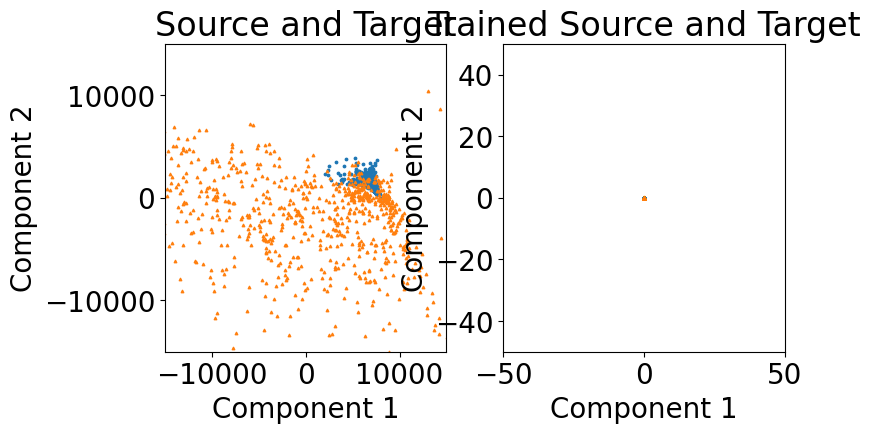

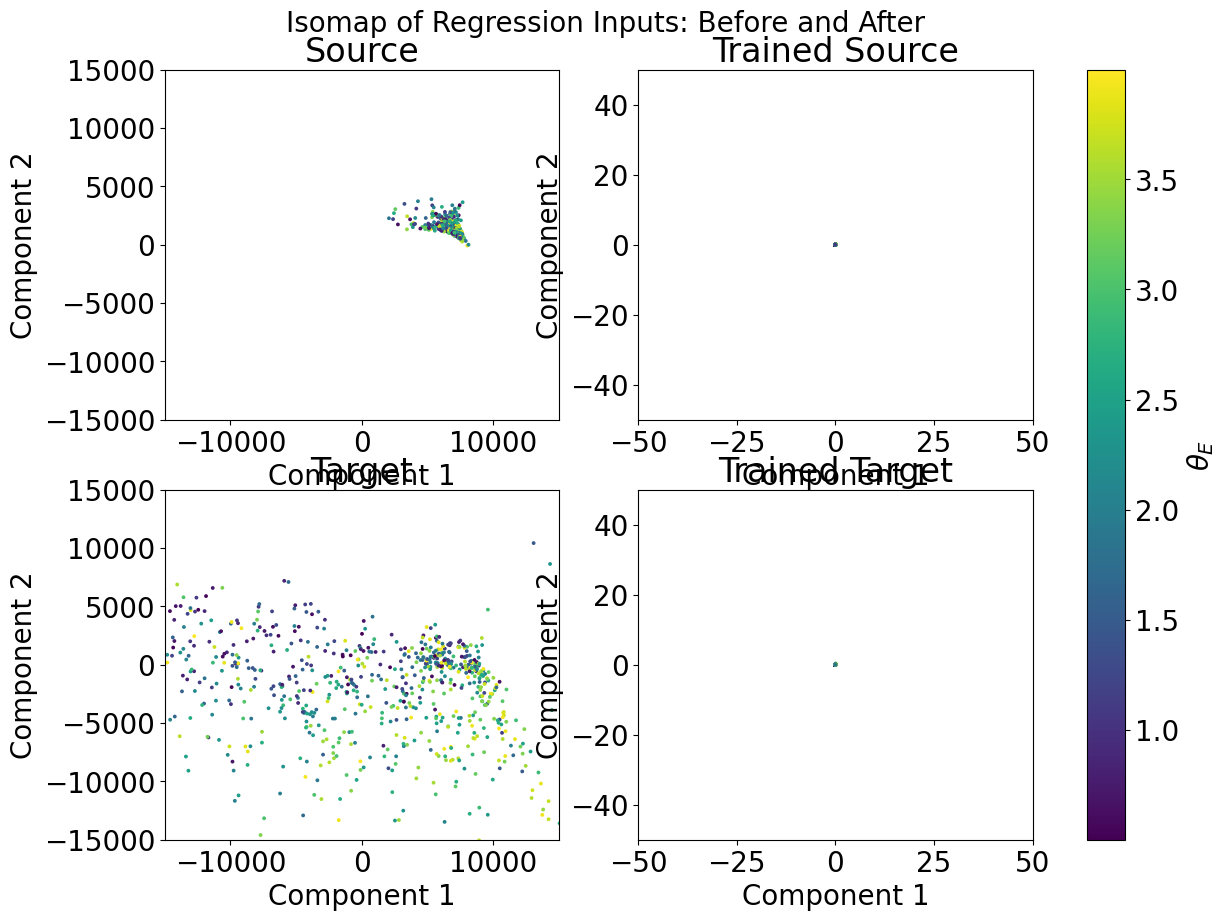


Epoch 95: 17.91s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1945
	Train Regression Loss: : 0.2434
	Train R2 Score: : 0.7529
 Validation Statistics:
	Val Source Regression Loss: : 0.2394
	Val Target Regression Loss: : 0.3653
	Val Source R2 Score: : 0.7530
	Val Target R2 Score: : 0.6329

Epoch 96: 14.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1947
	Train Regression Loss: : 0.2452
	Train R2 Score: : 0.7521
 Validation Statistics:
	Val Source Regression Loss: : 0.2312
	Val Target Regression Loss: : 0.3652
	Val Source R2 Score: : 0.7620
	Val Target R2 Score: : 0.6310

Epoch 97: 13.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1943
	Train Regression Loss: : 0.2462
	Train R2 Score: : 0.7512
 Validation Statistics:
	Val Source Regression Loss: : 0.2387
	Val Target Regression Loss: : 0.3663
	Val Source R2 Score: : 0.7569
	Val Target R2 Score: : 0.6262

Epoch 98: 15.05s
----------------------------

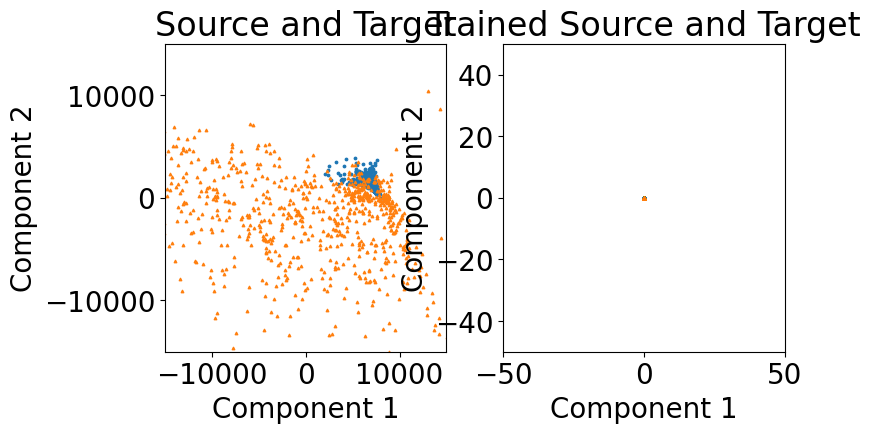

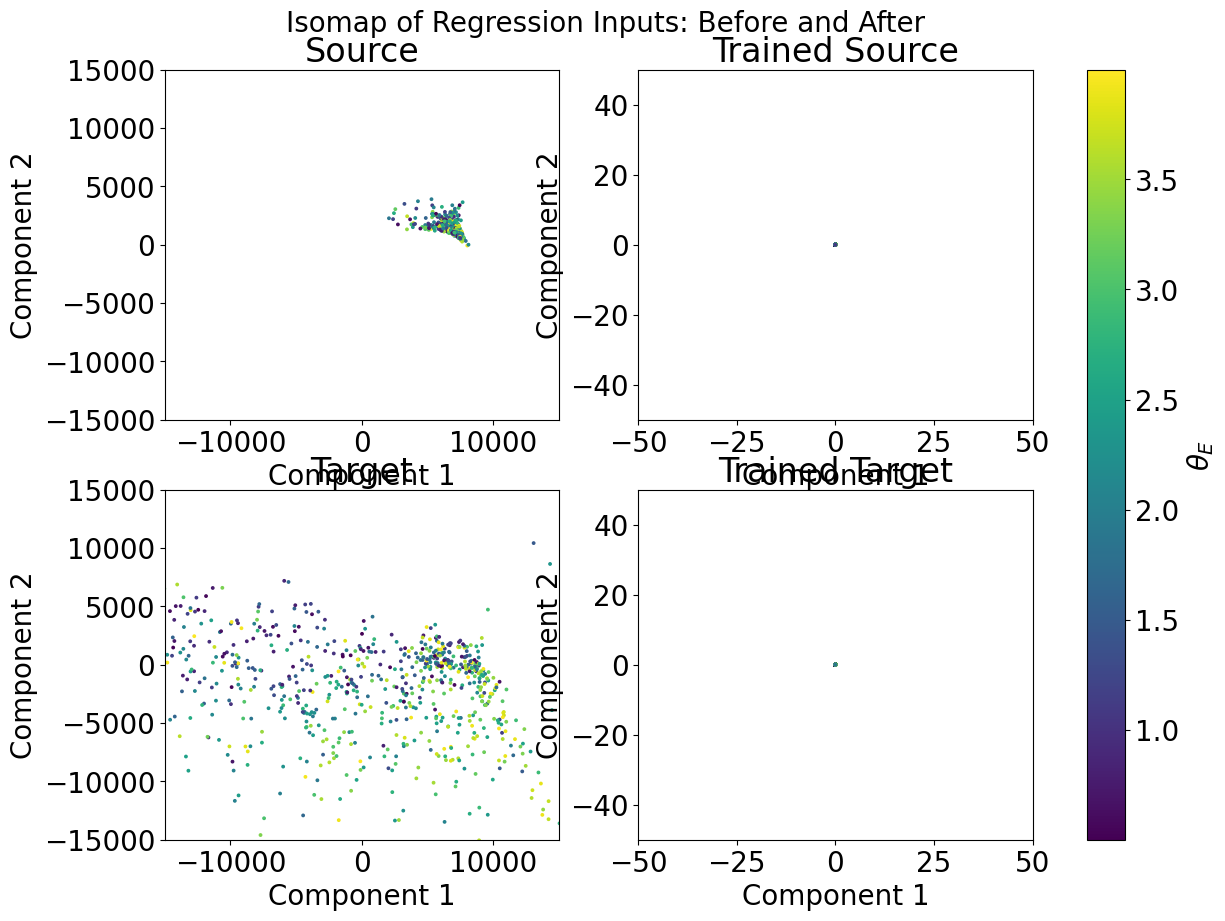


Epoch 100: 18.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1941
	Train Regression Loss: : 0.2524
	Train R2 Score: : 0.7442
 Validation Statistics:
	Val Source Regression Loss: : 0.2600
	Val Target Regression Loss: : 0.3831
	Val Source R2 Score: : 0.7316
	Val Target R2 Score: : 0.6123

Epoch 101: 17.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1918
	Train Regression Loss: : 0.2557
	Train R2 Score: : 0.7404
 Validation Statistics:
	Val Source Regression Loss: : 0.2547
	Val Target Regression Loss: : 0.3939
	Val Source R2 Score: : 0.7410
	Val Target R2 Score: : 0.5964

Epoch 102: 15.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1949
	Train Regression Loss: : 0.2573
	Train R2 Score: : 0.7386
 Validation Statistics:
	Val Source Regression Loss: : 0.2675
	Val Target Regression Loss: : 0.4047
	Val Source R2 Score: : 0.7235
	Val Target R2 Score: : 0.5844

Epoch 103: 17.14s
------------------------

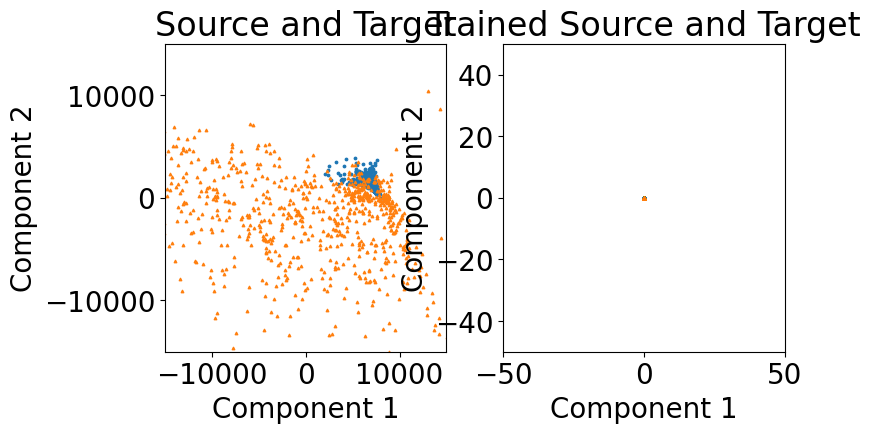

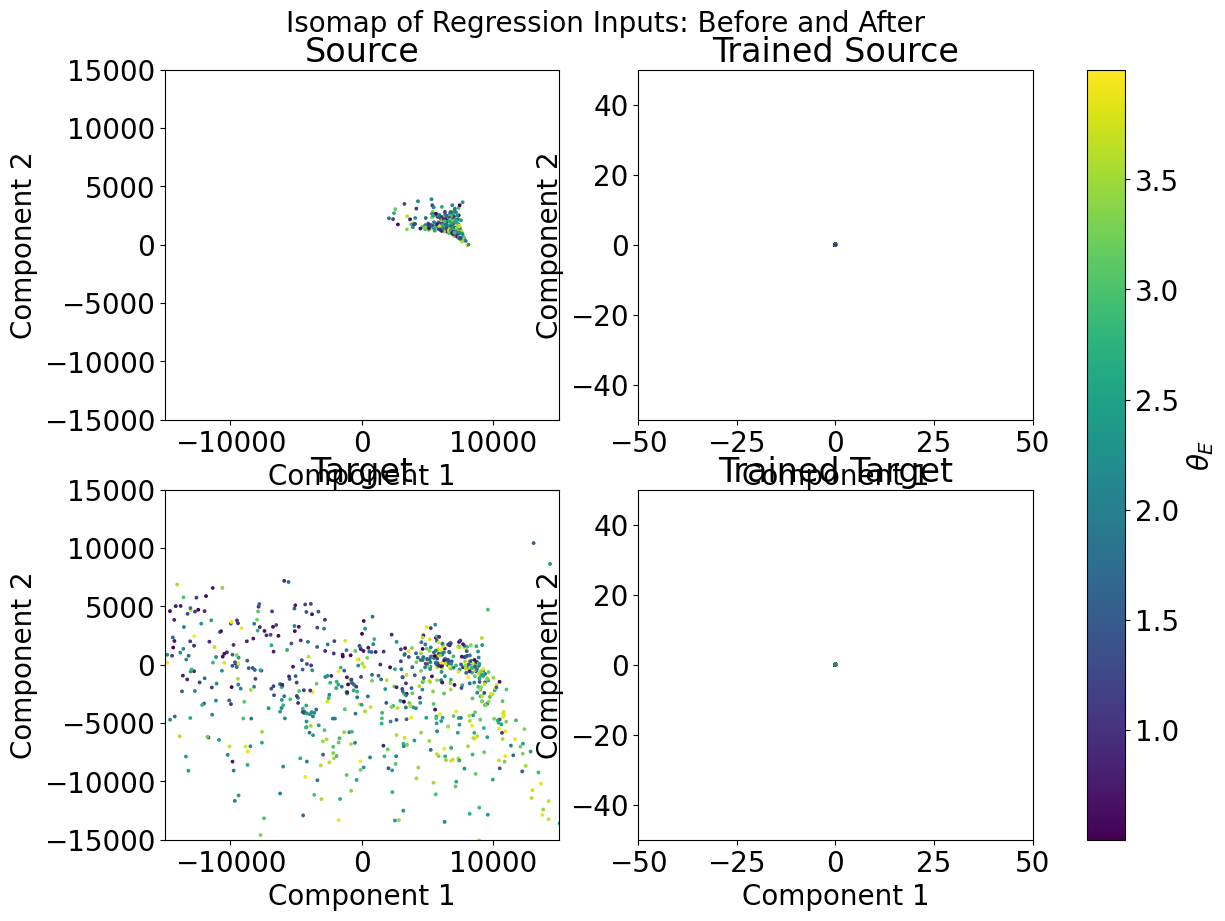


Epoch 105: 20.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1942
	Train Regression Loss: : 0.2631
	Train R2 Score: : 0.7341
 Validation Statistics:
	Val Source Regression Loss: : 0.3013
	Val Target Regression Loss: : 0.4593
	Val Source R2 Score: : 0.6902
	Val Target R2 Score: : 0.5369

Epoch 106: 18.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1945
	Train Regression Loss: : 0.2652
	Train R2 Score: : 0.7316
 Validation Statistics:
	Val Source Regression Loss: : 0.2744
	Val Target Regression Loss: : 0.3925
	Val Source R2 Score: : 0.7190
	Val Target R2 Score: : 0.6032

Epoch 107: 15.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1942
	Train Regression Loss: : 0.2669
	Train R2 Score: : 0.7294
 Validation Statistics:
	Val Source Regression Loss: : 0.2596
	Val Target Regression Loss: : 0.3944
	Val Source R2 Score: : 0.7334
	Val Target R2 Score: : 0.6004

Epoch 108: 15.50s
------------------------

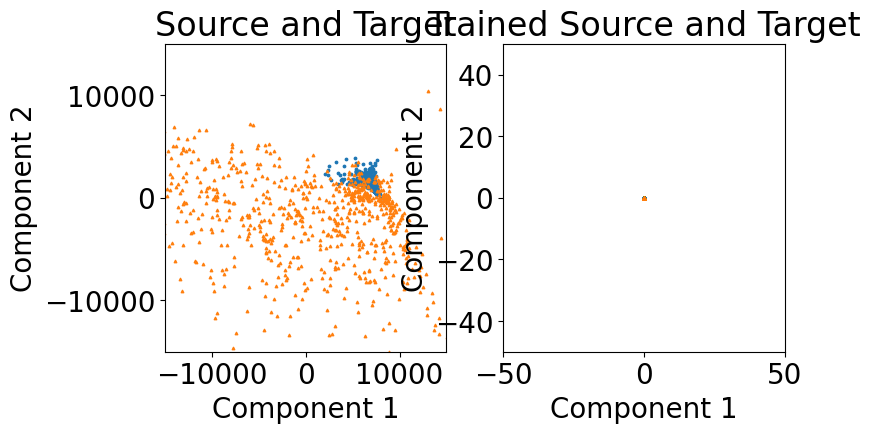

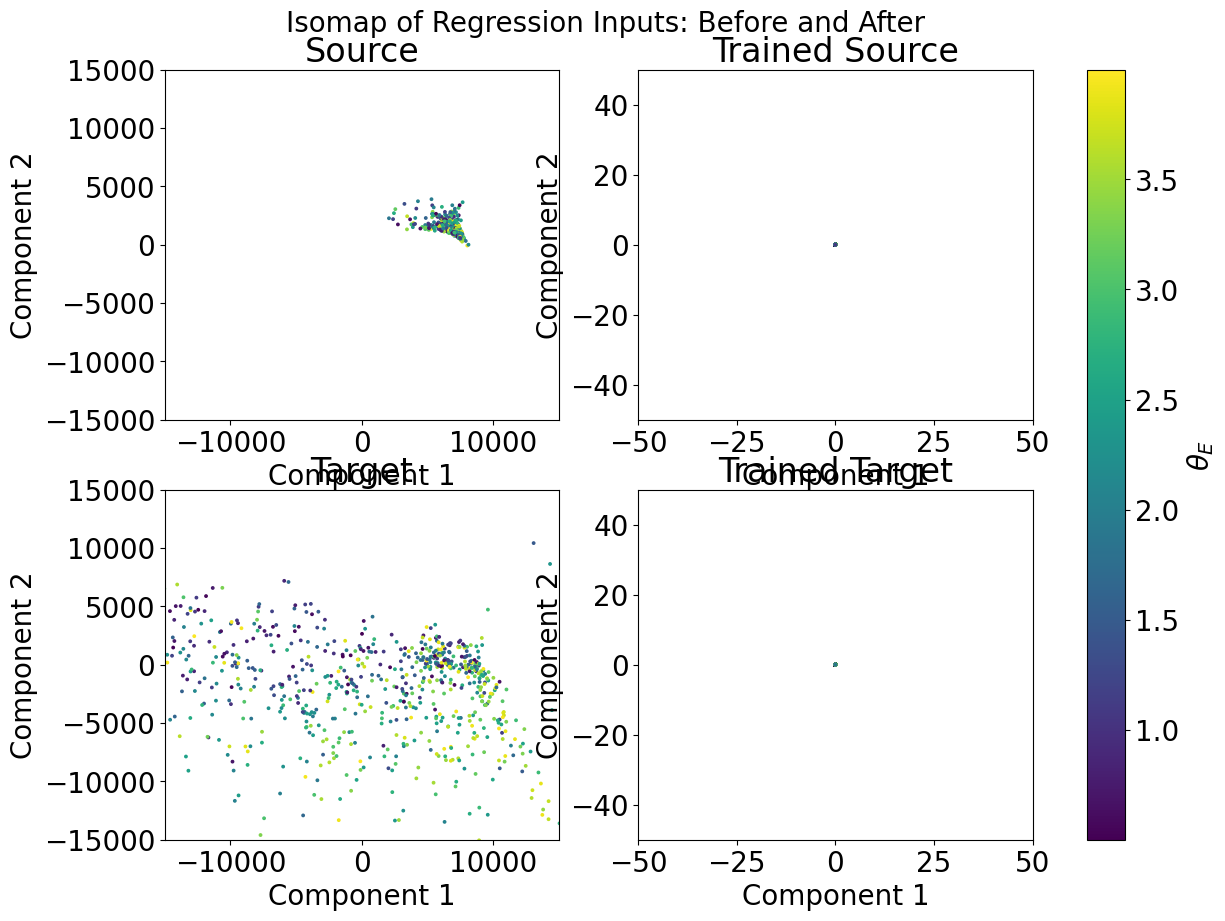


Epoch 110: 17.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1935
	Train Regression Loss: : 0.2665
	Train R2 Score: : 0.7301
 Validation Statistics:
	Val Source Regression Loss: : 0.2770
	Val Target Regression Loss: : 0.4161
	Val Source R2 Score: : 0.7175
	Val Target R2 Score: : 0.5790

Epoch 111: 16.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1951
	Train Regression Loss: : 0.2693
	Train R2 Score: : 0.7272
 Validation Statistics:
	Val Source Regression Loss: : 0.2577
	Val Target Regression Loss: : 0.3904
	Val Source R2 Score: : 0.7367
	Val Target R2 Score: : 0.6062

Epoch 112: 16.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1938
	Train Regression Loss: : 0.2734
	Train R2 Score: : 0.7233
 Validation Statistics:
	Val Source Regression Loss: : 0.2844
	Val Target Regression Loss: : 0.4109
	Val Source R2 Score: : 0.7077
	Val Target R2 Score: : 0.5879

Epoch 113: 15.58s
------------------------

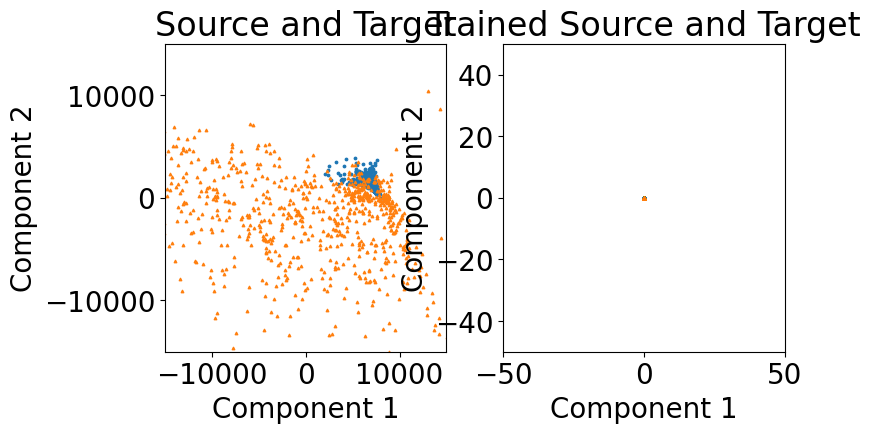

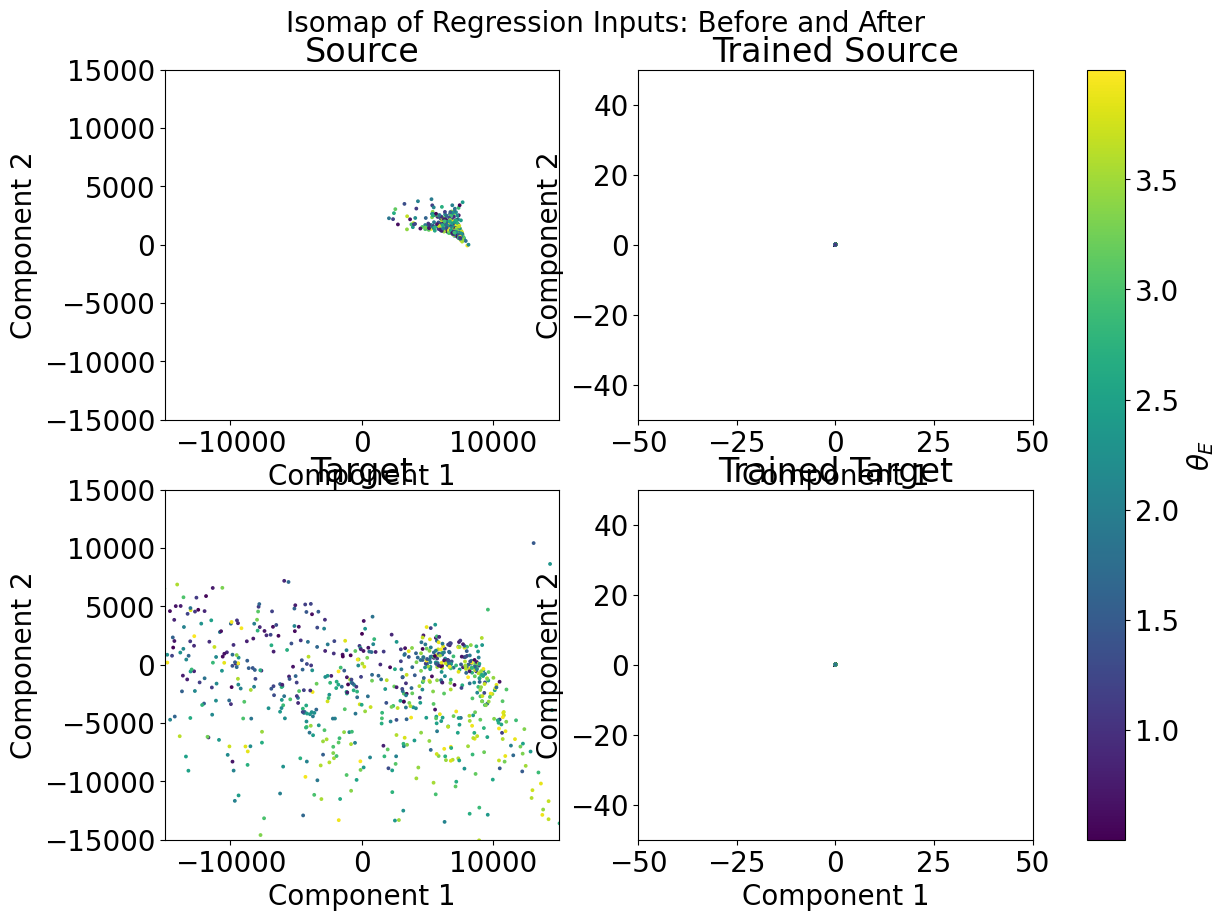


Epoch 115: 21.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1943
	Train Regression Loss: : 0.2723
	Train R2 Score: : 0.7238
 Validation Statistics:
	Val Source Regression Loss: : 0.2741
	Val Target Regression Loss: : 0.3890
	Val Source R2 Score: : 0.7183
	Val Target R2 Score: : 0.6070

Epoch 116: 15.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1935
	Train Regression Loss: : 0.2747
	Train R2 Score: : 0.7216
 Validation Statistics:
	Val Source Regression Loss: : 0.2608
	Val Target Regression Loss: : 0.3948
	Val Source R2 Score: : 0.7333
	Val Target R2 Score: : 0.6028

Epoch 117: 14.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1938
	Train Regression Loss: : 0.2755
	Train R2 Score: : 0.7206
 Validation Statistics:
	Val Source Regression Loss: : 0.2805
	Val Target Regression Loss: : 0.4296
	Val Source R2 Score: : 0.7111
	Val Target R2 Score: : 0.5673

Epoch 118: 15.94s
------------------------

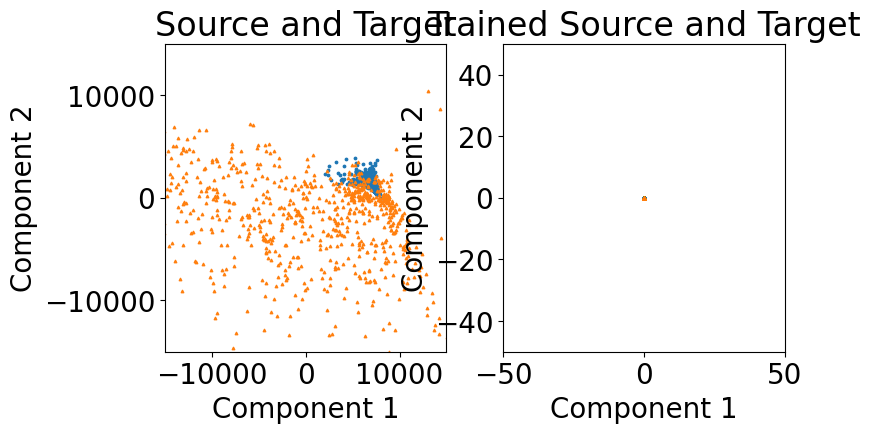

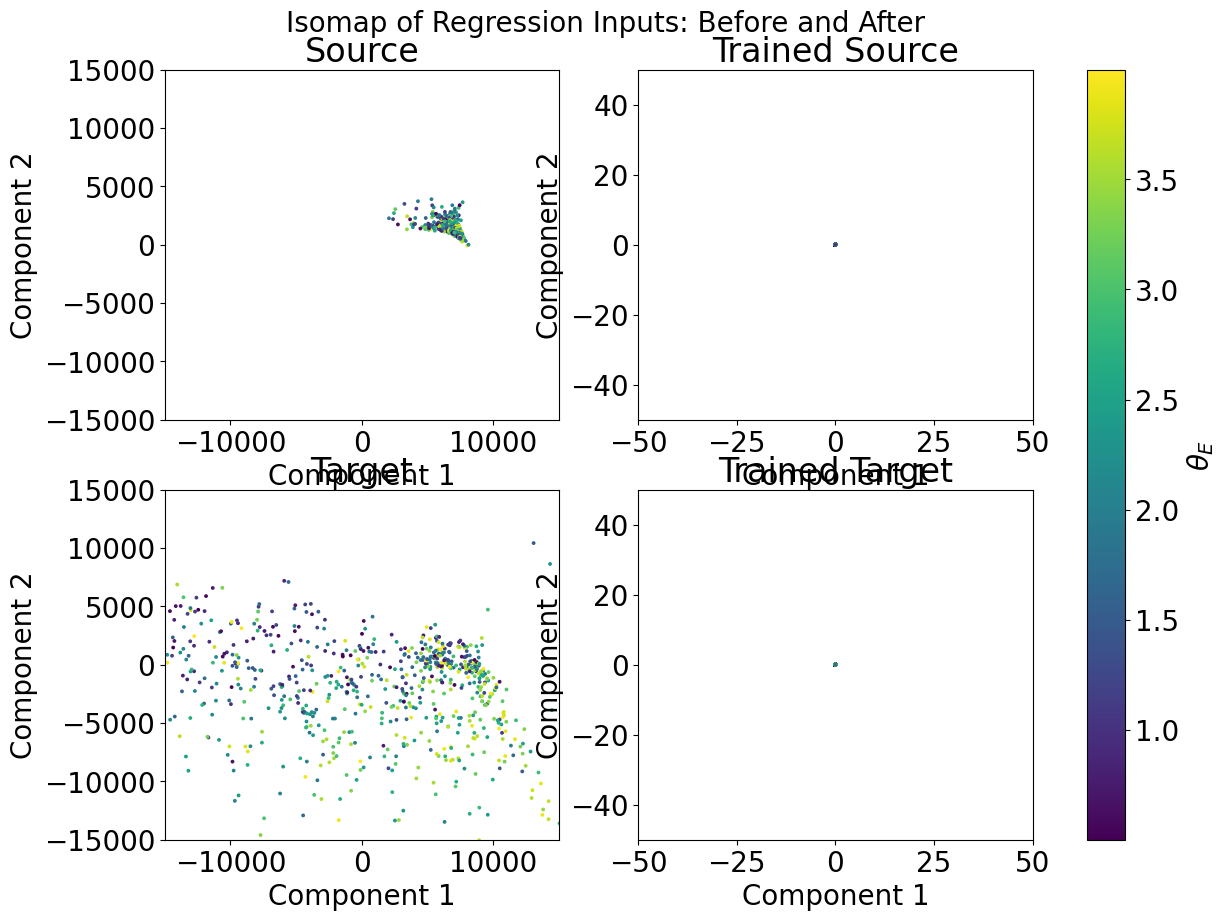


Epoch 120: 18.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1931
	Train Regression Loss: : 0.2800
	Train R2 Score: : 0.7167
 Validation Statistics:
	Val Source Regression Loss: : 0.2481
	Val Target Regression Loss: : 0.3738
	Val Source R2 Score: : 0.7438
	Val Target R2 Score: : 0.6154

Epoch 121: 16.61s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1938
	Train Regression Loss: : 0.2795
	Train R2 Score: : 0.7171
 Validation Statistics:
	Val Source Regression Loss: : 0.2878
	Val Target Regression Loss: : 0.4156
	Val Source R2 Score: : 0.7060
	Val Target R2 Score: : 0.5820

Epoch 122: 16.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1928
	Train Regression Loss: : 0.2841
	Train R2 Score: : 0.7122
 Validation Statistics:
	Val Source Regression Loss: : 0.2696
	Val Target Regression Loss: : 0.3933
	Val Source R2 Score: : 0.7211
	Val Target R2 Score: : 0.5991

Epoch 123: 18.31s
------------------------

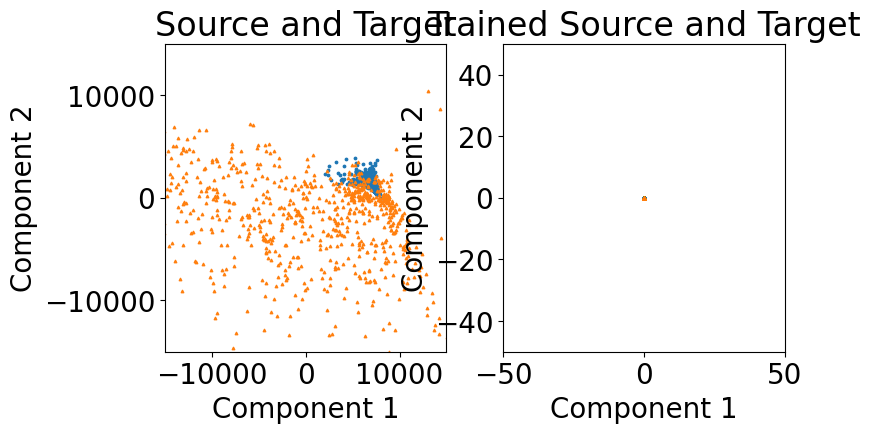

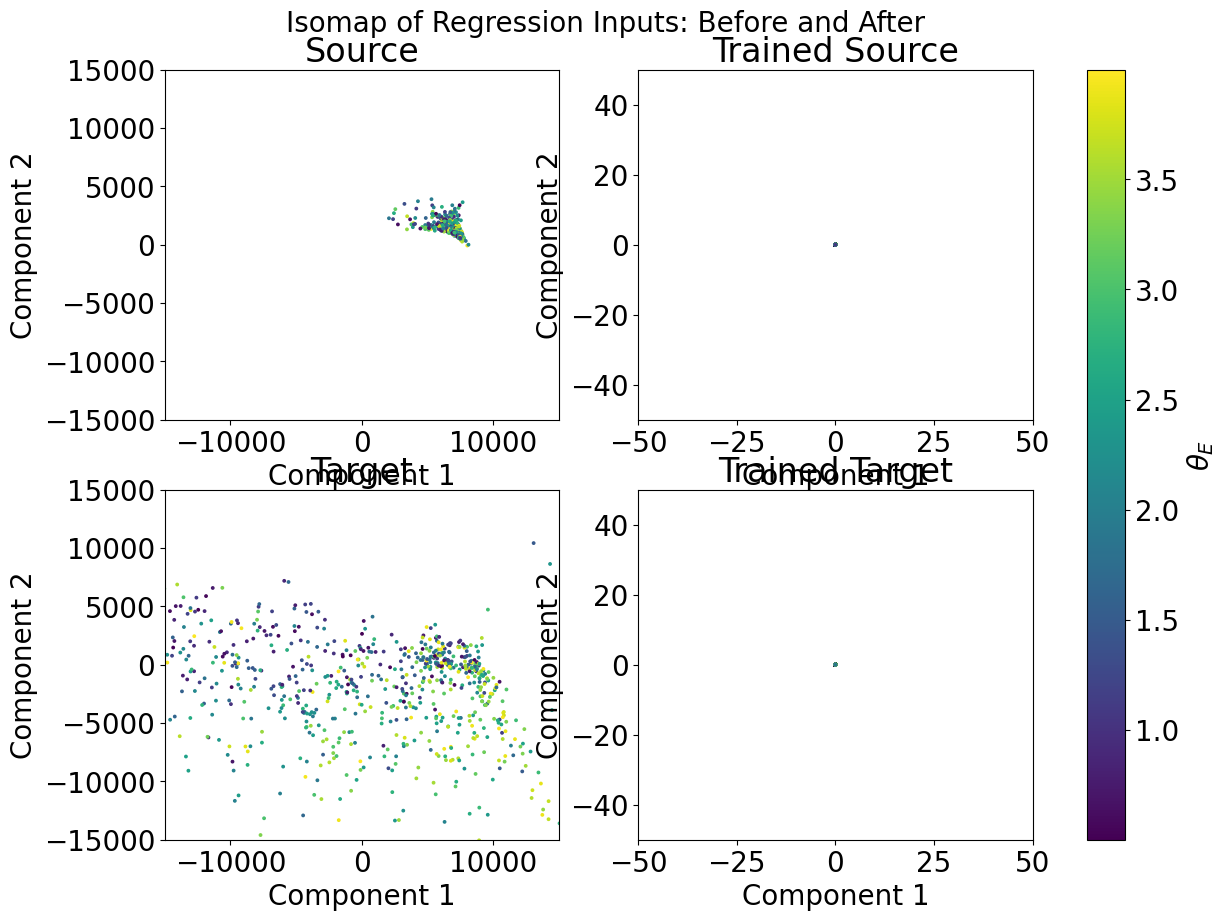


Epoch 125: 16.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1929
	Train Regression Loss: : 0.2819
	Train R2 Score: : 0.7147
 Validation Statistics:
	Val Source Regression Loss: : 0.2781
	Val Target Regression Loss: : 0.4003
	Val Source R2 Score: : 0.7158
	Val Target R2 Score: : 0.5976

Epoch 126: 16.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1921
	Train Regression Loss: : 0.2830
	Train R2 Score: : 0.7139
 Validation Statistics:
	Val Source Regression Loss: : 0.2678
	Val Target Regression Loss: : 0.3915
	Val Source R2 Score: : 0.7249
	Val Target R2 Score: : 0.5991

Epoch 127: 15.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1932
	Train Regression Loss: : 0.2852
	Train R2 Score: : 0.7107
 Validation Statistics:
	Val Source Regression Loss: : 0.2603
	Val Target Regression Loss: : 0.3899
	Val Source R2 Score: : 0.7304
	Val Target R2 Score: : 0.6089

Epoch 128: 16.39s
------------------------

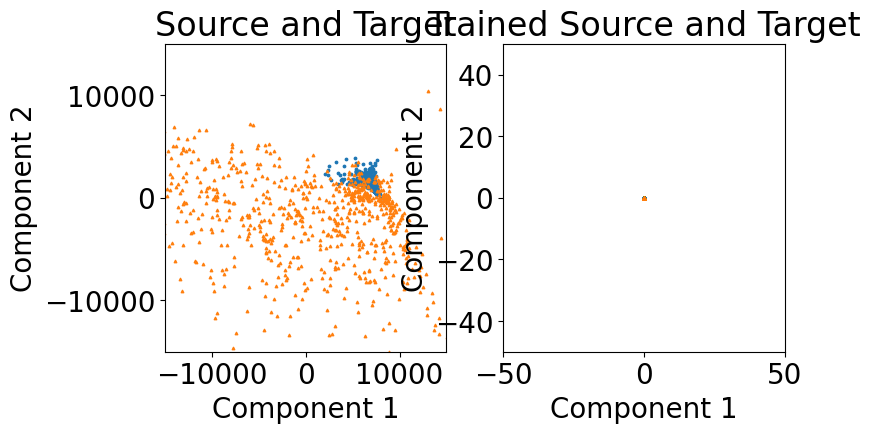

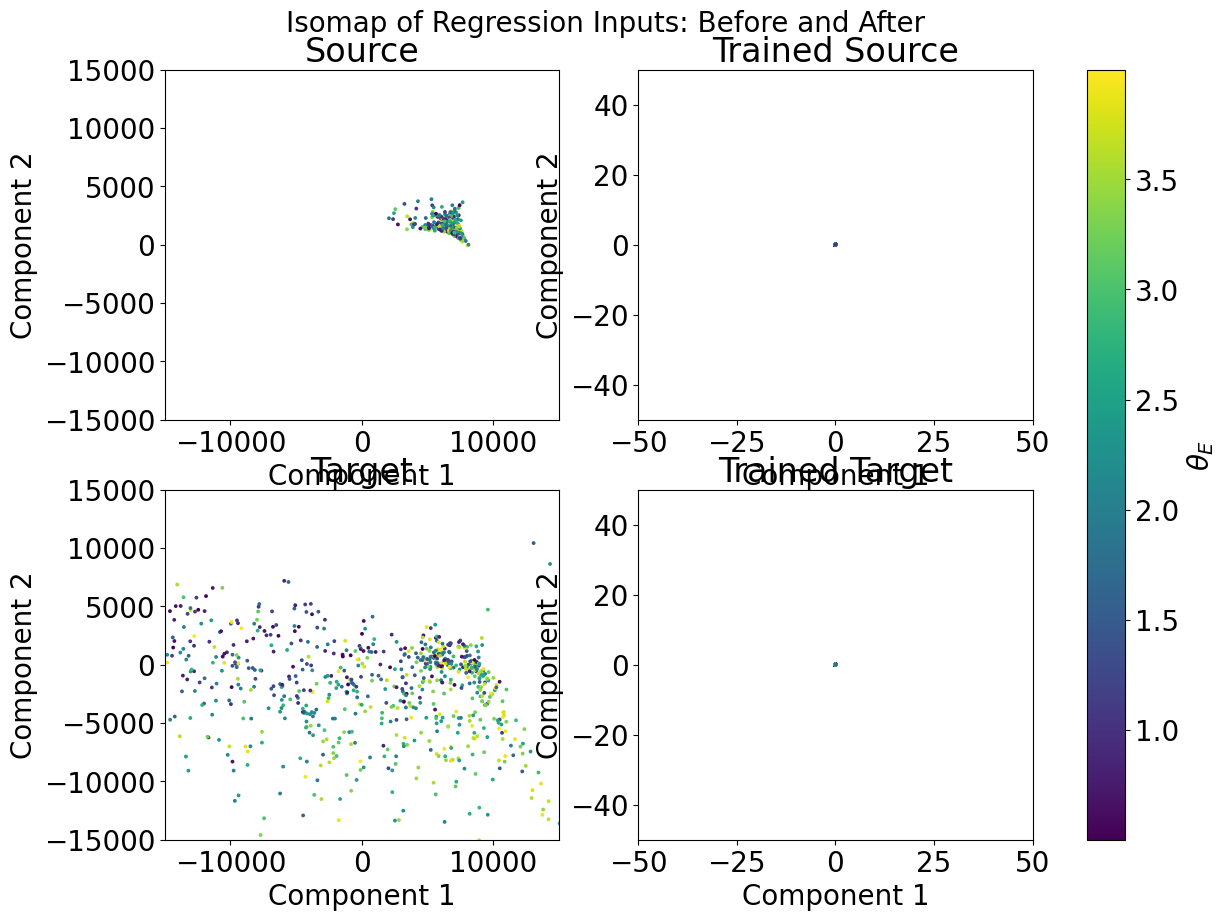


Epoch 130: 20.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1931
	Train Regression Loss: : 0.2821
	Train R2 Score: : 0.7151
 Validation Statistics:
	Val Source Regression Loss: : 0.2785
	Val Target Regression Loss: : 0.4212
	Val Source R2 Score: : 0.7138
	Val Target R2 Score: : 0.5755

Epoch 131: 15.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1931
	Train Regression Loss: : 0.2824
	Train R2 Score: : 0.7135
 Validation Statistics:
	Val Source Regression Loss: : 0.2769
	Val Target Regression Loss: : 0.4046
	Val Source R2 Score: : 0.7141
	Val Target R2 Score: : 0.5920

Epoch 132: 15.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1942
	Train Regression Loss: : 0.2863
	Train R2 Score: : 0.7095
 Validation Statistics:
	Val Source Regression Loss: : 0.2768
	Val Target Regression Loss: : 0.4202
	Val Source R2 Score: : 0.7159
	Val Target R2 Score: : 0.5752

Epoch 133: 15.93s
------------------------

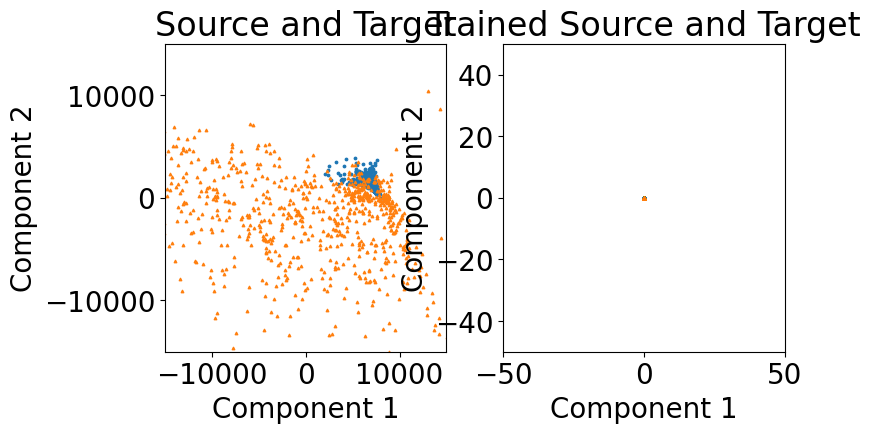

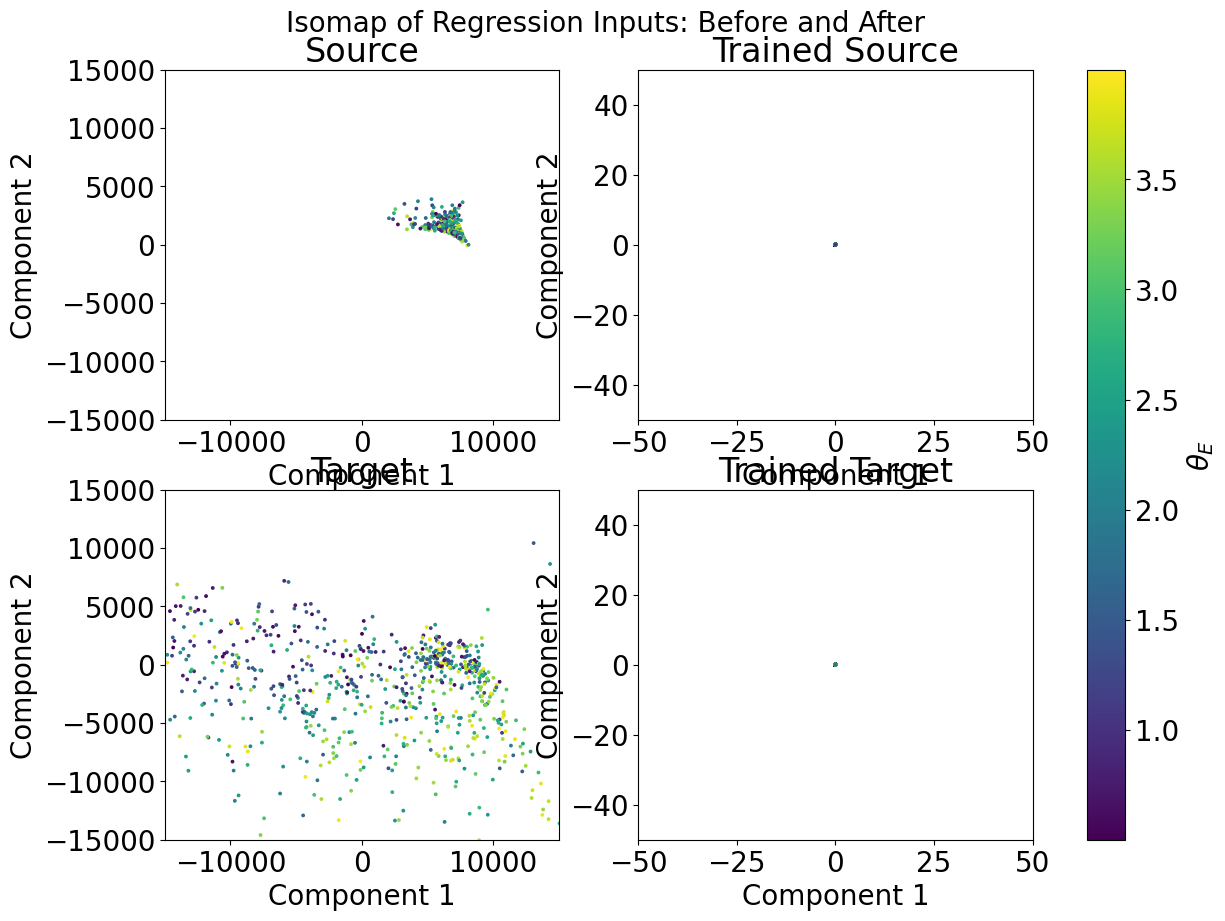


Epoch 135: 21.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1940
	Train Regression Loss: : 0.2857
	Train R2 Score: : 0.7093
 Validation Statistics:
	Val Source Regression Loss: : 0.2710
	Val Target Regression Loss: : 0.4220
	Val Source R2 Score: : 0.7214
	Val Target R2 Score: : 0.5710

Epoch 136: 16.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1937
	Train Regression Loss: : 0.2860
	Train R2 Score: : 0.7118
 Validation Statistics:
	Val Source Regression Loss: : 0.2878
	Val Target Regression Loss: : 0.4173
	Val Source R2 Score: : 0.7019
	Val Target R2 Score: : 0.5767

Epoch 137: 17.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1929
	Train Regression Loss: : 0.2886
	Train R2 Score: : 0.7077
 Validation Statistics:
	Val Source Regression Loss: : 0.2686
	Val Target Regression Loss: : 0.4041
	Val Source R2 Score: : 0.7234
	Val Target R2 Score: : 0.5959

Epoch 138: 18.13s
------------------------

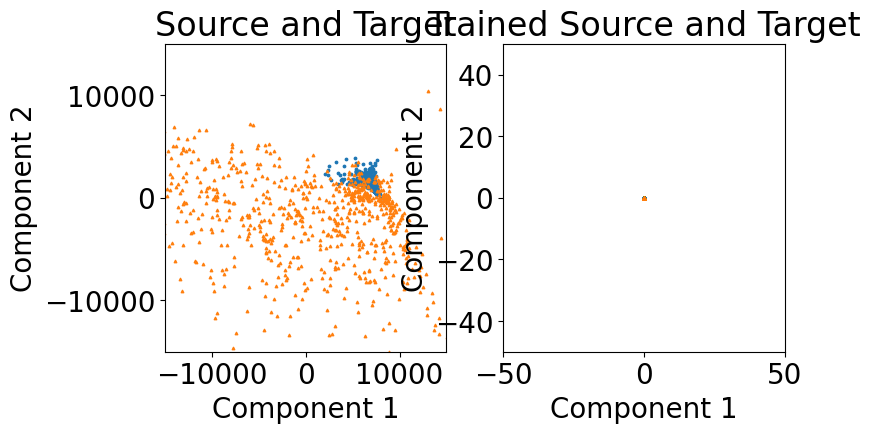

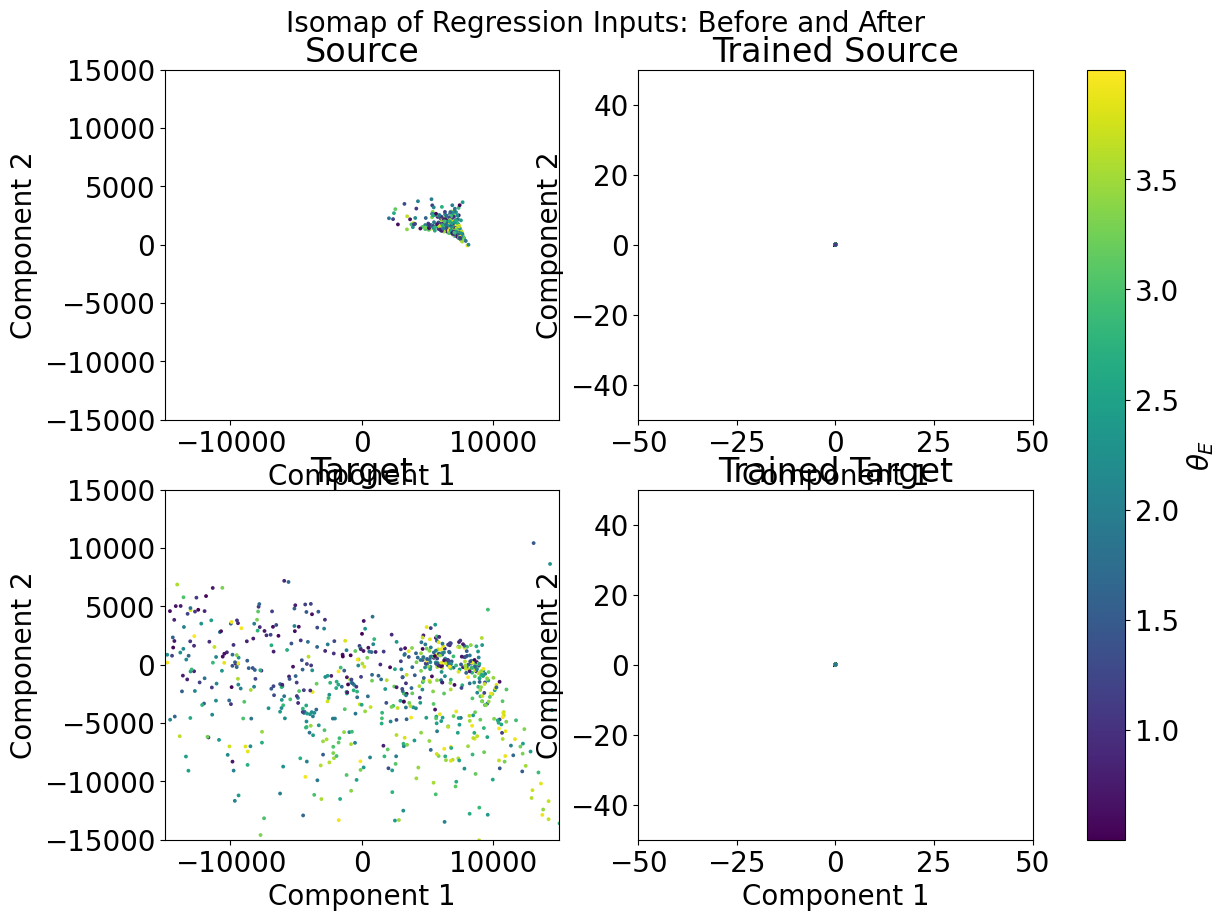


Epoch 140: 18.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1944
	Train Regression Loss: : 0.2899
	Train R2 Score: : 0.7063
 Validation Statistics:
	Val Source Regression Loss: : 0.3154
	Val Target Regression Loss: : 0.4689
	Val Source R2 Score: : 0.6768
	Val Target R2 Score: : 0.5290

Epoch 141: 16.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1940
	Train Regression Loss: : 0.2873
	Train R2 Score: : 0.7086
 Validation Statistics:
	Val Source Regression Loss: : 0.2596
	Val Target Regression Loss: : 0.3932
	Val Source R2 Score: : 0.7333
	Val Target R2 Score: : 0.6052

Epoch 142: 16.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1939
	Train Regression Loss: : 0.2868
	Train R2 Score: : 0.7095
 Validation Statistics:
	Val Source Regression Loss: : 0.2672
	Val Target Regression Loss: : 0.4080
	Val Source R2 Score: : 0.7264
	Val Target R2 Score: : 0.5896

Epoch 143: 14.74s
------------------------

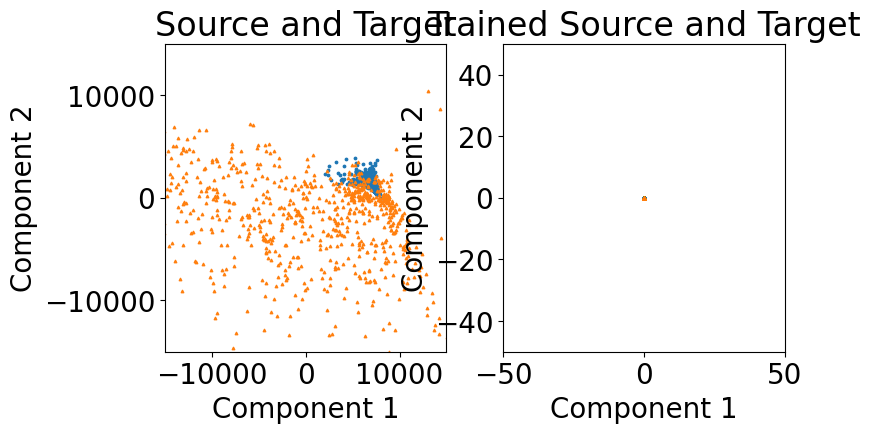

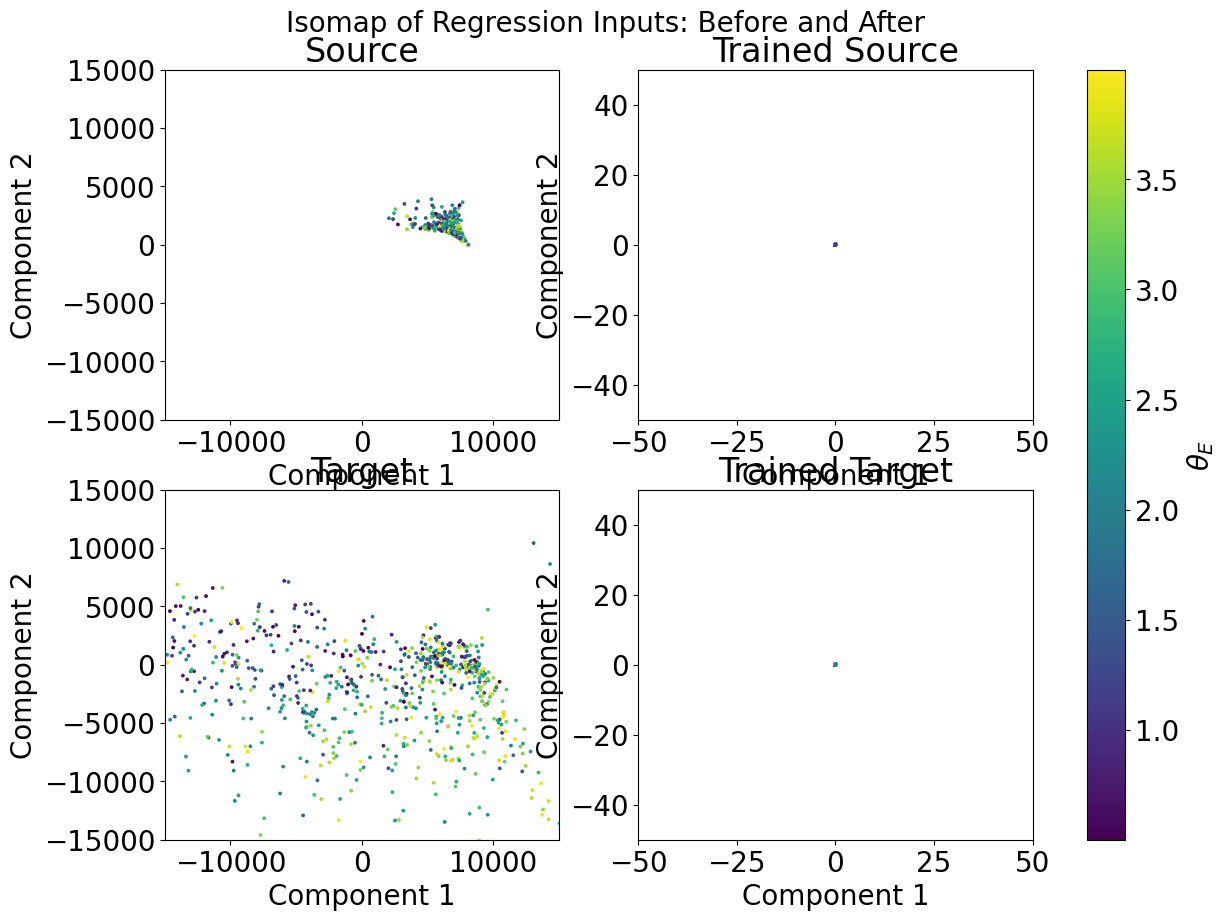


Epoch 145: 16.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1960
	Train Regression Loss: : 0.2865
	Train R2 Score: : 0.7084
 Validation Statistics:
	Val Source Regression Loss: : 0.2805
	Val Target Regression Loss: : 0.4368
	Val Source R2 Score: : 0.7116
	Val Target R2 Score: : 0.5543

Epoch 146: 17.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1940
	Train Regression Loss: : 0.2868
	Train R2 Score: : 0.7102
 Validation Statistics:
	Val Source Regression Loss: : 0.3183
	Val Target Regression Loss: : 0.4495
	Val Source R2 Score: : 0.6732
	Val Target R2 Score: : 0.5467

Epoch 147: 23.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1945
	Train Regression Loss: : 0.2872
	Train R2 Score: : 0.7084
 Validation Statistics:
	Val Source Regression Loss: : 0.2814
	Val Target Regression Loss: : 0.4320
	Val Source R2 Score: : 0.7110
	Val Target R2 Score: : 0.5646

Epoch 148: 17.24s
------------------------

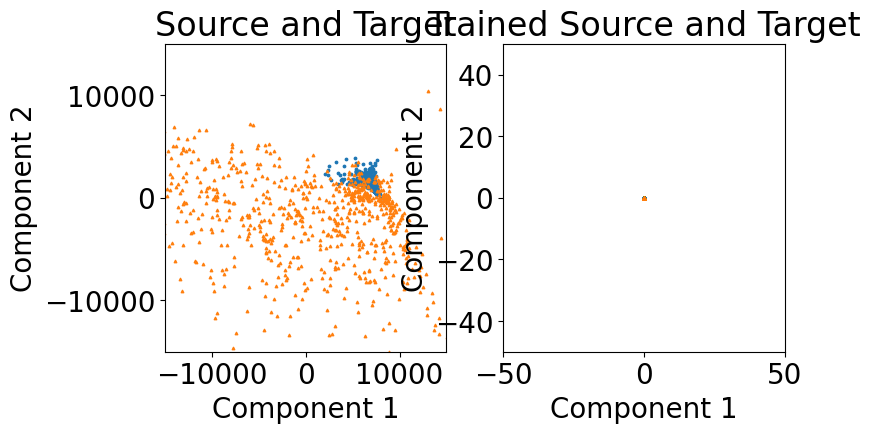

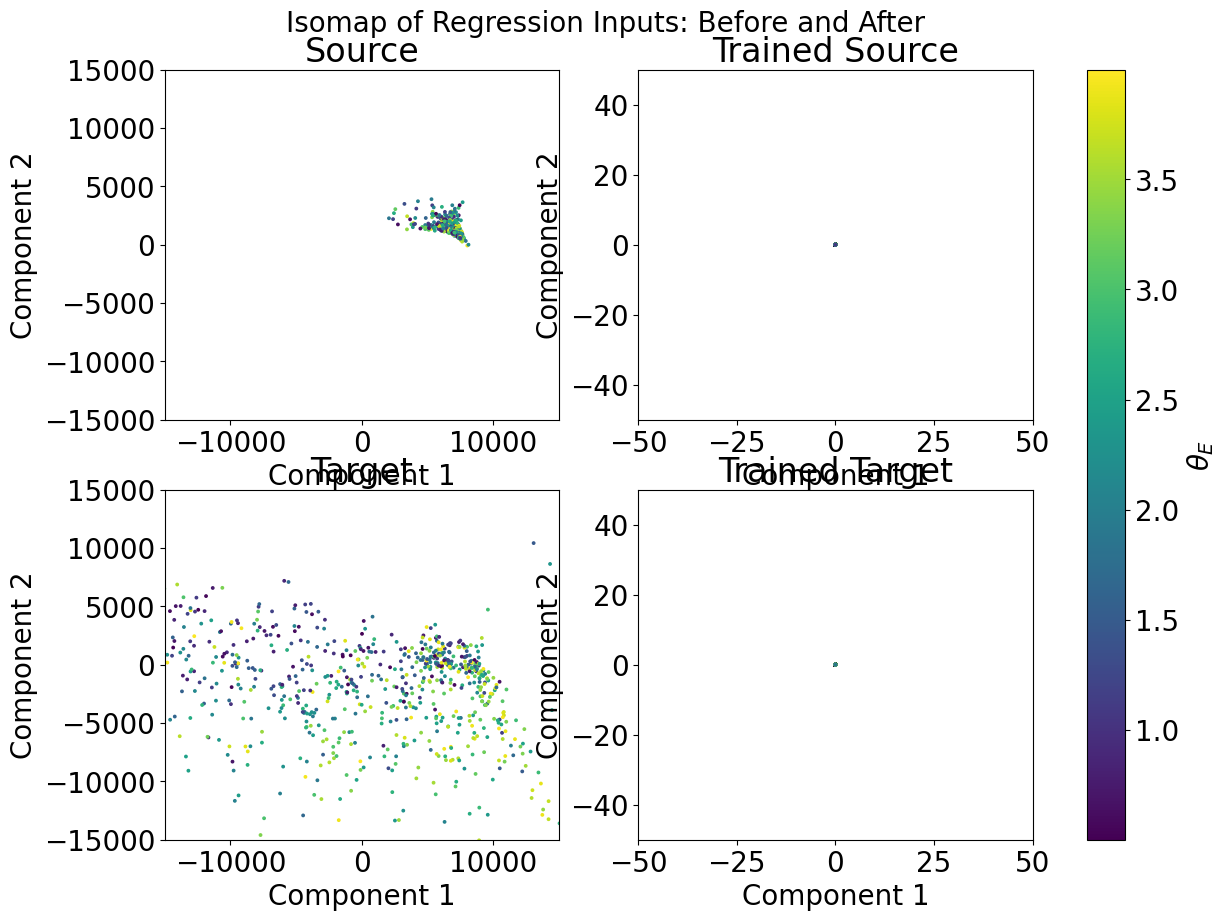


Epoch 150: 18.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1944
	Train Regression Loss: : 0.2902
	Train R2 Score: : 0.7043
 Validation Statistics:
	Val Source Regression Loss: : 0.3471
	Val Target Regression Loss: : 0.4823
	Val Source R2 Score: : 0.6443
	Val Target R2 Score: : 0.5137

Epoch 151: 15.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1955
	Train Regression Loss: : 0.2888
	Train R2 Score: : 0.7069
 Validation Statistics:
	Val Source Regression Loss: : 0.3132
	Val Target Regression Loss: : 0.4999
	Val Source R2 Score: : 0.6761
	Val Target R2 Score: : 0.4914

Epoch 152: 13.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1965
	Train Regression Loss: : 0.2862
	Train R2 Score: : 0.7091
 Validation Statistics:
	Val Source Regression Loss: : 0.2800
	Val Target Regression Loss: : 0.4432
	Val Source R2 Score: : 0.7105
	Val Target R2 Score: : 0.5527

Epoch 153: 15.46s
------------------------

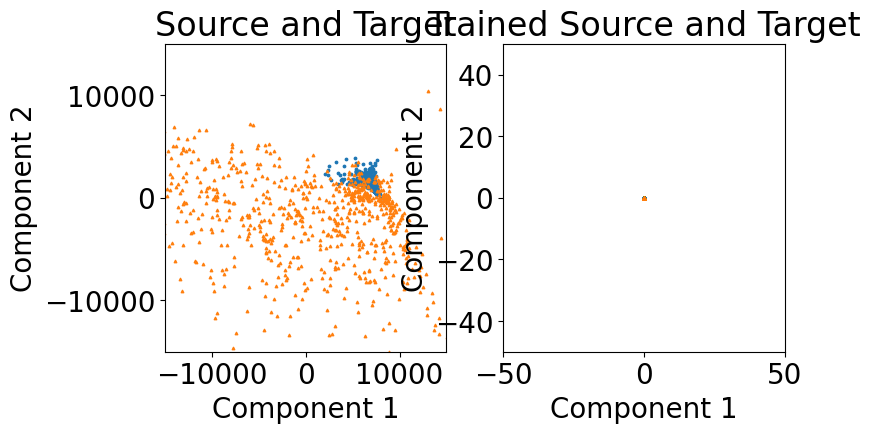

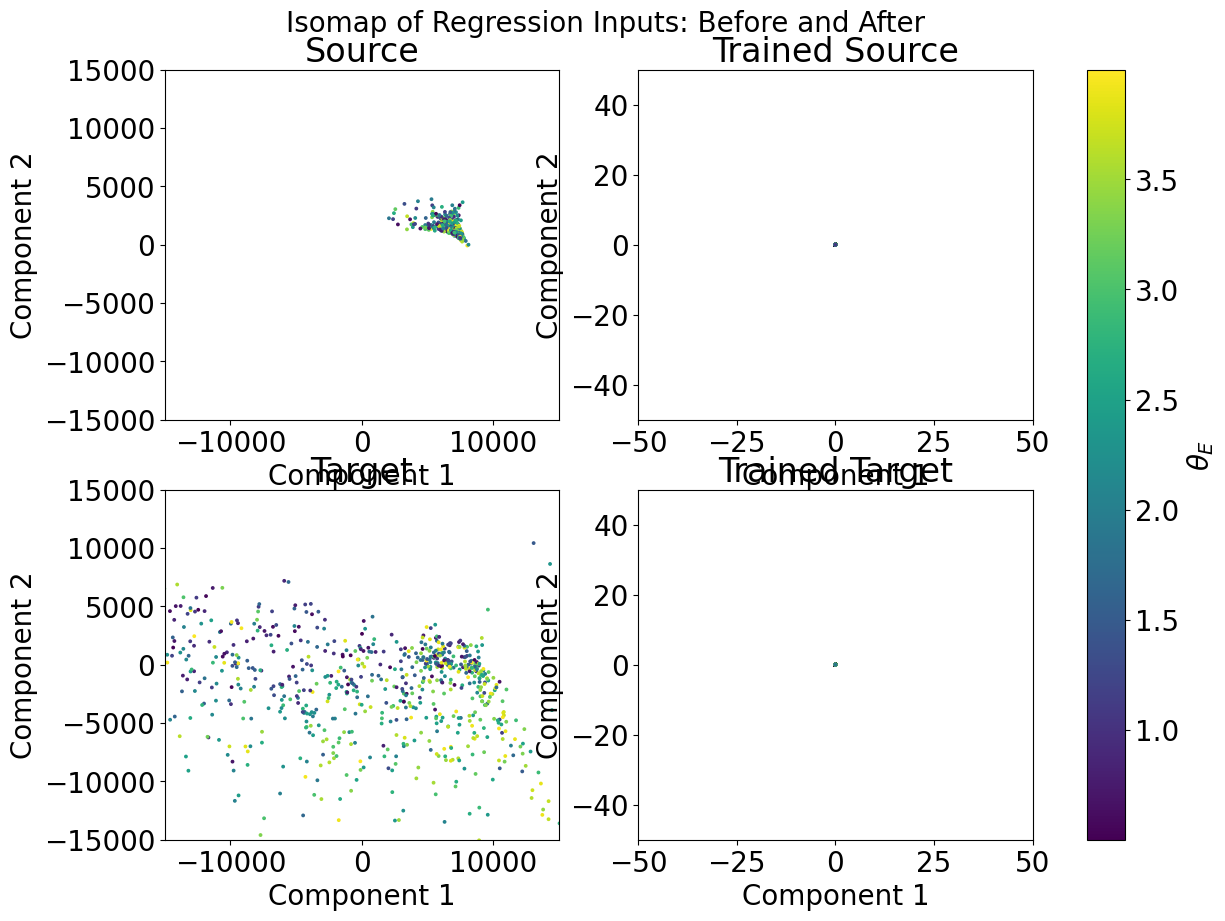


Epoch 155: 16.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1966
	Train Regression Loss: : 0.2872
	Train R2 Score: : 0.7076
 Validation Statistics:
	Val Source Regression Loss: : 0.2592
	Val Target Regression Loss: : 0.4230
	Val Source R2 Score: : 0.7340
	Val Target R2 Score: : 0.5709

Epoch 156: 16.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1959
	Train Regression Loss: : 0.2845
	Train R2 Score: : 0.7126
 Validation Statistics:
	Val Source Regression Loss: : 0.2779
	Val Target Regression Loss: : 0.4243
	Val Source R2 Score: : 0.7149
	Val Target R2 Score: : 0.5732

Epoch 157: 15.89s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1957
	Train Regression Loss: : 0.2915
	Train R2 Score: : 0.7039
 Validation Statistics:
	Val Source Regression Loss: : 0.2678
	Val Target Regression Loss: : 0.4292
	Val Source R2 Score: : 0.7244
	Val Target R2 Score: : 0.5647

Epoch 158: 15.63s
------------------------

In [ ]:
print("Beginning Training...")
mod_name = "models/mb_lenscolor_jul25_1440"
# Train
best_target_R2 = -1
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, 2.5, 1.8)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['epoch_no'] += 1

        if stats['val_target_r2_score'] > best_target_R2:
            state = {
                    'epoch': stats['epoch_no'],
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    }
            torch.save(state, mod_name)
            best_target_R2 = stats['val_target_r2_score']
    
        print_epoch_scores(stats, i, time.time() - start_time)

In [ ]:
state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [10]:
mod_name = "models/mb_isomap_jul25_0200"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

In [21]:
def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [33]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [34]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

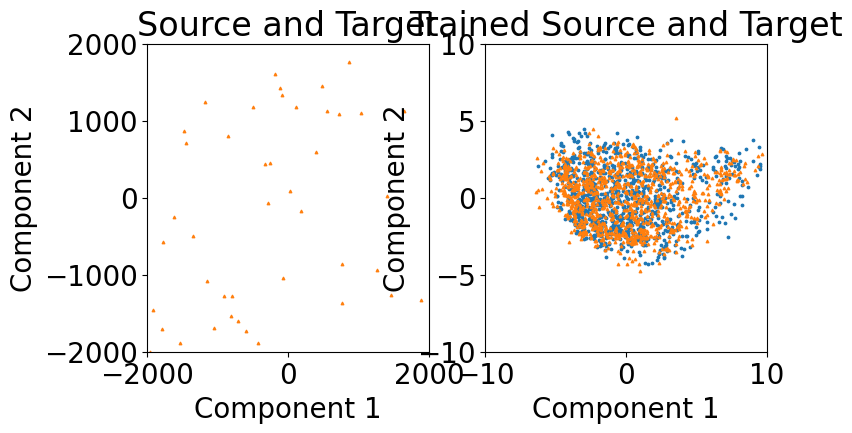

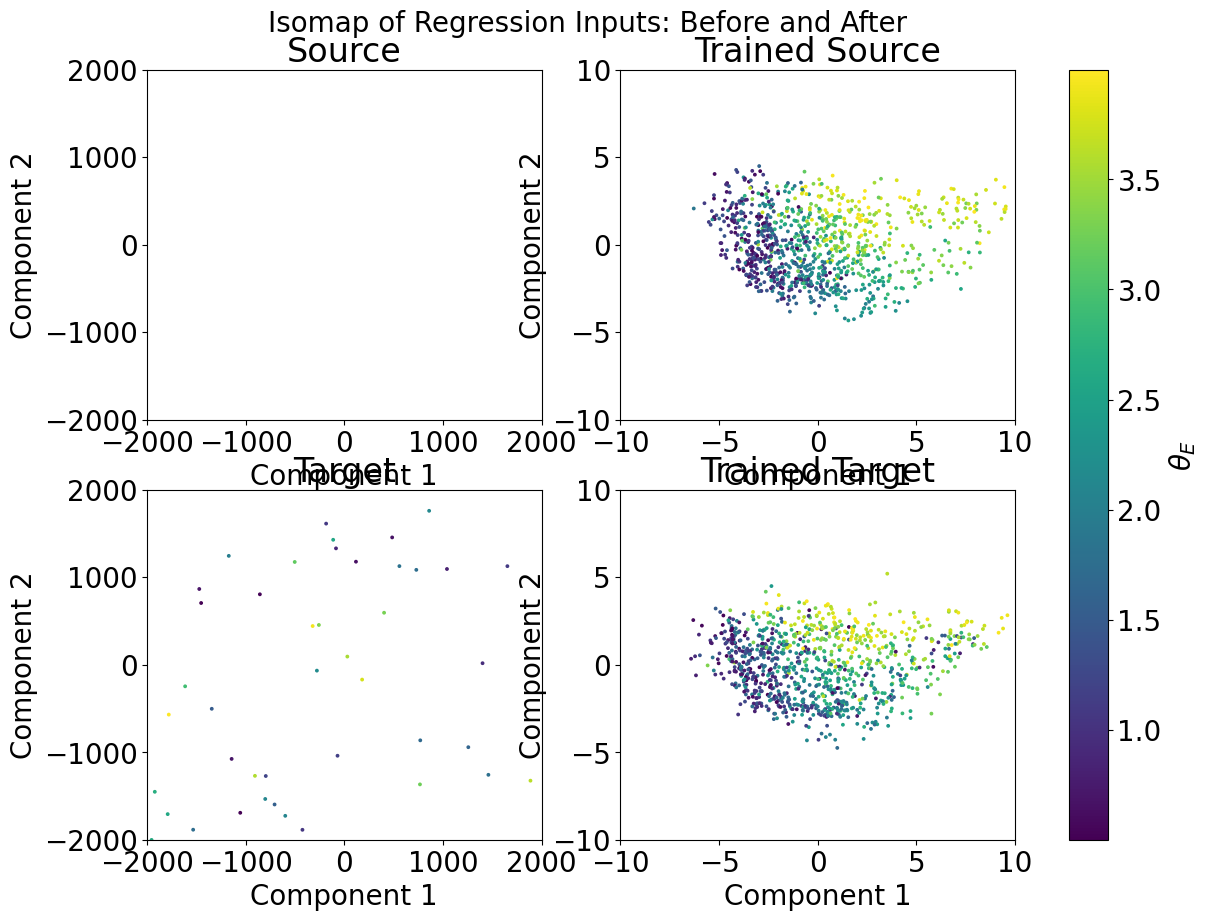

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [36]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 2000, 10)

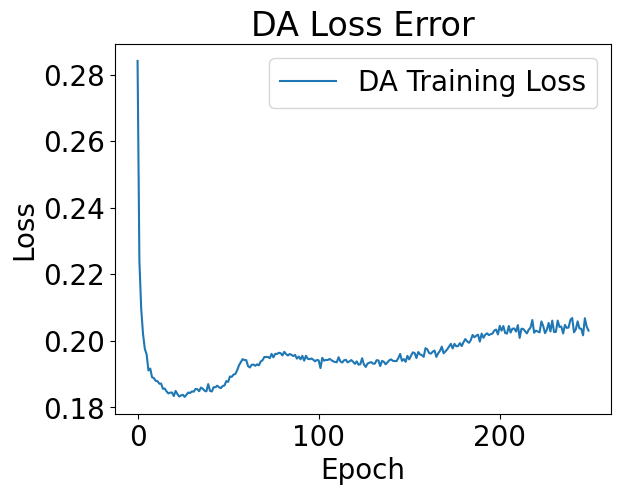

In [48]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

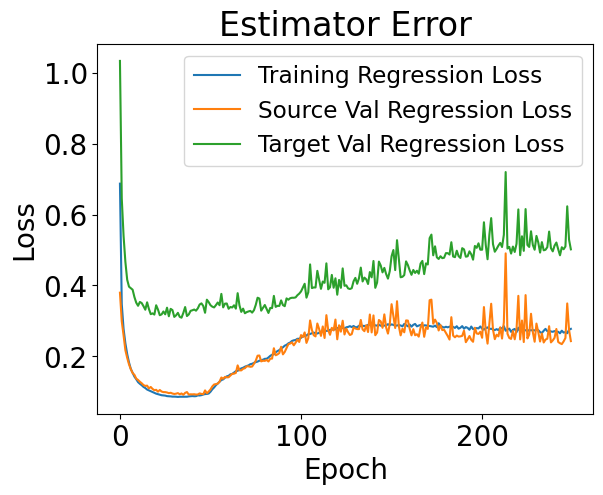

In [49]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

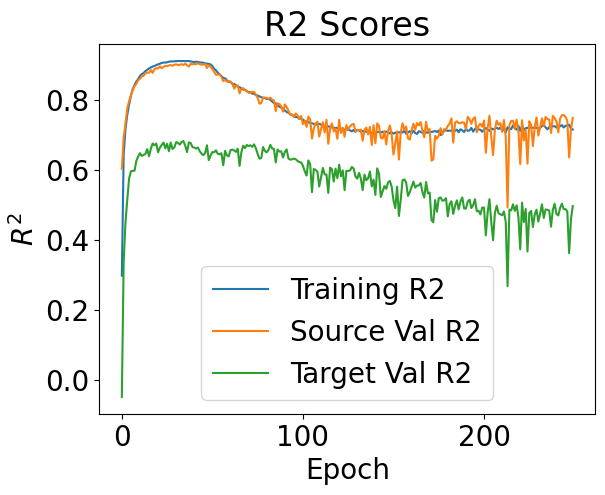

In [50]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.7488


Text(0.5, 1.0, 'MMD | Source | R2: 0.749')

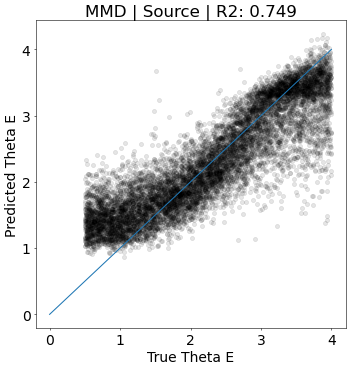

In [51]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.4799


Text(0.5, 1.0, 'MMD | Target | R2: 0.480')

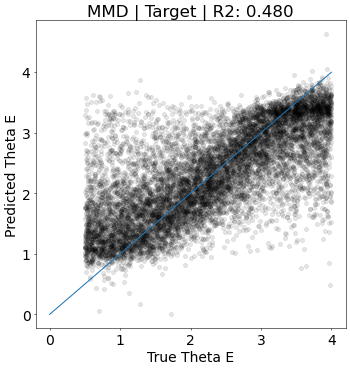

In [52]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))